# **Credit Scorecard Model**

Author : Althaaf Athaayaa Daffa Qushayyizidane 

---

### **Background**

>I am involved in a project with the company Home Credit Indonesia. I will be collaborating with various other departments in this project to provide technology solutions for the company. I was asked to build a credit score model to ensure that customers who are able to make repayments are not rejected when applying for a loan, and that loans are given with a principal, maturity, and repayment calendar that will motivate customers to succeed. In addition, I also had to provide business recommendations for the company.<br>

## **Import Library**

---

In [77]:
# Melakukan import library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import boxcox
from imblearn import under_sampling, over_sampling
import gdown
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, fbeta_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, reset_parameter, LGBMClassifier

import shap

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [78]:
def check_library_versions():
    libraries = [
        'numpy', 'pandas', 'seaborn', 'scipy', 'matplotlib', 'sklearn',
        'imblearn', 'gdown', 'mlxtend', 'xgboost', 'lightgbm', 'shap'
    ]

    for lib in libraries:
        try:
            module = __import__(lib)
            print(f"{lib.capitalize()}: {module.__version__}")
        except ImportError:
            print(f"{lib.capitalize()}: Not installed")
        except AttributeError:
            print(f"{lib.capitalize()}: No version attribute")

check_library_versions()

Numpy: 1.26.4
Pandas: 2.1.4
Seaborn: 0.13.2
Scipy: 1.11.4
Matplotlib: 3.8.0
Sklearn: 1.2.1
Imblearn: 0.9.1
Gdown: 4.7.3
Mlxtend: 0.23.1
Xgboost: 2.0.3
Lightgbm: 4.3.0
Shap: 0.45.0


In [79]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [80]:
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

## **LOAD DATA**
---

In [81]:
df = pd.read_csv("application_train.csv")
df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

### **CHECKING SPECIAL CHARACTER**

In [83]:
import re

# Function to detect special characters and digit-letter combinations
def detect_special_character(column):
    pattern = r'[!@#$%^&*<>/]|[0-9][a-zA-Z]|[a-zA-Z][0-9]'
    return column.apply(lambda x: bool(re.search(pattern, str(x))))

# Function to detect special characters and digit-letter combinations
def clear_special_character(column):
    pattern = r'[!@#$%^&*<>/]|[0-9][a-zA-Z]|[a-zA-Z][0-9]'
    return column.apply(lambda x: re.sub(pattern, '', str(x)))


categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Checking column: {col}")
    if detect_special_character(df[col]).any():
        print(f"Special characters or digit-letter combinations found in column: {col}")

        # Clean special characters and digit-letter combinations
        df[col] = clear_special_character(df[col])
        print(f"Column {col} has been cleaned")

Checking column: NAME_CONTRACT_TYPE
Checking column: CODE_GENDER
Checking column: FLAG_OWN_CAR
Checking column: FLAG_OWN_REALTY
Checking column: NAME_TYPE_SUITE
Checking column: NAME_INCOME_TYPE
Checking column: NAME_EDUCATION_TYPE
Special characters or digit-letter combinations found in column: NAME_EDUCATION_TYPE
Column NAME_EDUCATION_TYPE has been cleaned
Checking column: NAME_FAMILY_STATUS
Special characters or digit-letter combinations found in column: NAME_FAMILY_STATUS
Column NAME_FAMILY_STATUS has been cleaned
Checking column: NAME_HOUSING_TYPE
Special characters or digit-letter combinations found in column: NAME_HOUSING_TYPE
Column NAME_HOUSING_TYPE has been cleaned
Checking column: OCCUPATION_TYPE
Special characters or digit-letter combinations found in column: OCCUPATION_TYPE
Column OCCUPATION_TYPE has been cleaned
Checking column: WEEKDAY_APPR_PROCESS_START
Checking column: ORGANIZATION_TYPE
Checking column: FONDKAPREMONT_MODE
Checking column: HOUSETYPE_MODE
Checking column

### **SELECTED RELEVANT FEATURE**

In [84]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
def encode_categorical_variables(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df

# Function to handle missing values with threshold
def handle_missing_values(df, threshold=0.7):
    missing_percentage = df.isnull().mean()  # Calculate missing value percentage for each column
    columns_to_drop = missing_percentage[missing_percentage >= threshold].index  # Columns with missing value >= threshold
    df.drop(columns=columns_to_drop, inplace=True)  # Drop those columns

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)  # Impute categorical columns with mode
        else:
            df[col].fillna(df[col].mean(), inplace=True)  # Impute numerical columns with mean
    return df

# Preprocess the data
def preprocess_data(df):
    df = encode_categorical_variables(df)
    df = handle_missing_values(df)
    return df


df = preprocess_data(df)



X = df.drop(columns=['TARGET'])
y = df['TARGET']


# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

def get_feature_importance(model):
    feature_importance =  pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    return feature_importance

feature_importance = get_feature_importance(model)

def top_features(feature_importance):
    top_features = feature_importance.index[:20].tolist()
    return top_features

top_features = top_features(feature_importance)

# Print the top features
print("Top Features based on feature importances:")
print(top_features)

Top Features based on feature importances:
['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'SK_ID_CURR', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'AMT_CREDIT', 'EXT_SOURCE_1', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'WEEKDAY_APPR_PROCESS_START', 'OCCUPATION_TYPE', 'OWN_CAR_AGE']


In [85]:
df_top_features = df[top_features]
df_model = pd.concat([df_top_features, y], axis=1)
df_model.head(5)

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,SK_ID_CURR,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,...,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
0,0.262949,0.139376,-9461,-2120,-3648.0,100002,24700.5,-637,-1134.0,406597.5,...,202500.0,0.018801,351000.0,10,5,1.000000,6,8,12.061091,1
1,0.622246,0.510853,-16765,-291,-1186.0,100003,35698.5,-1188,-828.0,1293502.5,...,270000.0,0.003541,1129500.0,11,39,0.000000,1,3,12.061091,0
2,0.555912,0.729567,-19046,-2531,-4260.0,100004,6750.0,-225,-815.0,135000.0,...,67500.0,0.010032,135000.0,9,11,0.000000,1,8,26.000000,0
3,0.650442,0.510853,-19005,-2437,-9833.0,100006,29686.5,-3039,-617.0,312682.5,...,135000.0,0.008019,297000.0,17,5,1.899974,6,8,12.061091,0
4,0.322738,0.510853,-19932,-3458,-4311.0,100007,21865.5,-3038,-1106.0,513000.0,...,121500.0,0.028663,513000.0,11,37,0.000000,4,3,12.061091,0


## **DATA PREPROCESSING**

>### **CLEANING**

In [86]:
df_preprocess = df_model.copy()

In [87]:
df_preprocess.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   EXT_SOURCE_2                307511 non-null  float64
 1   EXT_SOURCE_3                307511 non-null  float64
 2   DAYS_BIRTH                  307511 non-null  int64  
 3   DAYS_ID_PUBLISH             307511 non-null  int64  
 4   DAYS_REGISTRATION           307511 non-null  float64
 5   SK_ID_CURR                  307511 non-null  int64  
 6   AMT_ANNUITY                 307511 non-null  float64
 7   DAYS_EMPLOYED               307511 non-null  int64  
 8   DAYS_LAST_PHONE_CHANGE      307511 non-null  float64
 9   AMT_CREDIT                  307511 non-null  float64
 10  EXT_SOURCE_1                307511 non-null  float64
 11  AMT_INCOME_TOTAL            307511 non-null  float64
 12  REGION_POPULATION_RELATIVE  307511 non-null  float64
 13  AMT_GOODS_PRIC

**Checking Duplicate**

---

In [88]:
# Checking for duplicates
duplicates = df_preprocess.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Removing duplicates
df_preprocess.drop_duplicates(inplace=True)

Number of duplicate rows: 0


Secara keseluruhan, **tidak terdapat data duplikat** pada dataset

>### **EXPLORATORY DATA ANALYSIS**

In [89]:
for column in df_preprocess.columns:
    print(f"============= {column} =================")
    display(df_preprocess[column].value_counts())
    print()

============= EXT_SOURCE_2 =================


EXT_SOURCE_2
0.285898    721
0.514393    660
0.262258    417
0.265256    343
0.159679    322
           ... 
0.004725      1
0.257313      1
0.282030      1
0.181540      1
0.267834      1
Name: count, Length: 119832, dtype: int64


============= EXT_SOURCE_3 =================


EXT_SOURCE_3
0.510853    60965
0.746300     1460
0.713631     1315
0.694093     1276
0.670652     1191
            ...  
0.028674        1
0.025272        1
0.021492        1
0.014556        1
0.043227        1
Name: count, Length: 815, dtype: int64


============= DAYS_BIRTH =================


DAYS_BIRTH
-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
          ..
-24898     1
-24868     1
-8017      1
-25098     1
-25061     1
Name: count, Length: 17460, dtype: int64


============= DAYS_ID_PUBLISH =================


DAYS_ID_PUBLISH
-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
        ... 
-5896      1
-5921      1
-5753      1
-5960      1
-6211      1
Name: count, Length: 6168, dtype: int64


============= DAYS_REGISTRATION =================


DAYS_REGISTRATION
-1.0        113
-7.0         98
-6.0         96
-4.0         92
-2.0         92
           ... 
-15581.0      1
-15031.0      1
-14804.0      1
-15008.0      1
-14798.0      1
Name: count, Length: 15688, dtype: int64


============= SK_ID_CURR =================


SK_ID_CURR
100002    1
337664    1
337661    1
337660    1
337659    1
         ..
218992    1
218991    1
218990    1
218989    1
456255    1
Name: count, Length: 307511, dtype: int64


============= AMT_ANNUITY =================


AMT_ANNUITY
9000.0      6385
13500.0     5514
6750.0      2279
10125.0     2035
37800.0     1602
            ... 
79902.0        1
106969.5       1
60885.0        1
59661.0        1
77809.5        1
Name: count, Length: 13673, dtype: int64


============= DAYS_EMPLOYED =================


DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: count, Length: 12574, dtype: int64


============= DAYS_LAST_PHONE_CHANGE =================


DAYS_LAST_PHONE_CHANGE
 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-3713.0        1
-3978.0        1
-3983.0        1
-3739.0        1
-3538.0        1
Name: count, Length: 3774, dtype: int64


============= AMT_CREDIT =================


AMT_CREDIT
450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
487318.5        1
630400.5        1
1875276.0       1
1395895.5       1
1391130.0       1
Name: count, Length: 5603, dtype: int64


============= EXT_SOURCE_1 =================


EXT_SOURCE_1
0.502130    173378
0.581015         5
0.546426         5
0.443982         5
0.765724         5
             ...  
0.658473         1
0.318295         1
0.834644         1
0.485406         1
0.734460         1
Name: count, Length: 114585, dtype: int64


============= AMT_INCOME_TOTAL =================


AMT_INCOME_TOTAL
135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
117324.0        1
64584.0         1
142897.5        1
109170.0        1
113062.5        1
Name: count, Length: 2548, dtype: int64


============= REGION_POPULATION_RELATIVE =================


REGION_POPULATION_RELATIVE
0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: count, Length: 81, dtype: int64


============= AMT_GOODS_PRICE =================


AMT_GOODS_PRICE
450000.0     26022
225000.0     25282
675000.0     24962
900000.0     15416
270000.0     11428
             ...  
447606.0         1
2106000.0        1
894654.0         1
323982.0         1
743863.5         1
Name: count, Length: 1003, dtype: int64


============= HOUR_APPR_PROCESS_START =================


HOUR_APPR_PROCESS_START
10    37722
11    37229
12    34233
13    30959
14    27682
9     27384
15    24839
16    20385
8     15127
17    14900
7      9131
18     9049
6      5842
19     3848
5      3638
4      2090
3      1230
20     1196
21      405
2       305
22      150
1        86
23       41
0        40
Name: count, dtype: int64


============= ORGANIZATION_TYPE =================


ORGANIZATION_TYPE
5     67992
57    55374
42    38412
33    16683
30    11193
4     10553
11    10404
39     8893
51     7831
28     6880
7      6721
3      5984
55     5398
47     3492
26     3368
20     3278
40     3247
13     2958
16     2704
31     2634
2      2507
1      2454
34     2341
53     2204
35     2157
41     1974
46     1900
38     1811
43     1575
56     1327
24     1307
54     1187
14     1039
12      966
9       950
21      877
50      631
22      599
27      597
44      577
10      560
19      458
0       429
36      396
8       379
17      369
45      348
32      317
29      305
6       260
52      201
23      112
15      109
37       85
18       67
48       64
49       49
25       24
Name: count, dtype: int64


============= AMT_REQ_CREDIT_BUREAU_YEAR =================


AMT_REQ_CREDIT_BUREAU_YEAR
0.000000     71801
1.000000     63405
2.000000     50192
1.899974     41519
3.000000     33628
4.000000     20714
5.000000     12052
6.000000      6967
7.000000      3869
8.000000      2127
9.000000      1096
11.000000       31
12.000000       30
10.000000       22
13.000000       19
14.000000       10
17.000000        7
15.000000        6
19.000000        4
18.000000        4
16.000000        3
25.000000        1
23.000000        1
22.000000        1
21.000000        1
20.000000        1
Name: count, dtype: int64


============= WEEKDAY_APPR_PROCESS_START =================


WEEKDAY_APPR_PROCESS_START
5    53901
6    51934
1    50714
4    50591
0    50338
2    33852
3    16181
Name: count, dtype: int64


============= OCCUPATION_TYPE =================


OCCUPATION_TYPE
18    96391
8     55186
14    32102
3     27570
10    21371
4     18603
6     11380
0      9813
11     8537
16     6721
2      5946
1      4653
12     2652
9      2093
17     1348
15     1305
13      751
5       563
7       526
Name: count, dtype: int64


============= OWN_CAR_AGE =================


OWN_CAR_AGE
12.061091    202929
7.000000       7424
6.000000       6382
3.000000       6370
8.000000       5887
              ...  
57.000000         1
69.000000         1
50.000000         1
47.000000         1
52.000000         1
Name: count, Length: 63, dtype: int64


============= TARGET =================


TARGET
0    282686
1     24825
Name: count, dtype: int64

**Group Columns by Type**

---

In [90]:
# Group columns by their data types
numeric_columns = df_preprocess.select_dtypes(include=['number', 'int64', 'float64', 'int32']).columns.tolist()
categorical_columns = df_preprocess.select_dtypes(include=['object', 'bool']).columns.tolist()


In [91]:

# Exploratory Data Analysis (EDA)
# Summary of numeric columns
numeric_summary = df_preprocess[numeric_columns].describe()

# # Summary of categorical columns
# categorical_summary = df_preprocess[categorical_columns].describe()

# Display the summaries
print("Numeric Columns Summary:")
display(numeric_summary)

# print("\nCategorical Columns Summary:")
# display(categorical_summary)


Numeric Columns Summary:


,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,SK_ID_CURR,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,...,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
count,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,...,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,5.143927e-01,0.510853,-16036.995067,-2994.202373,-4986.120328,278180.518577,27108.573909,63815.045904,-962.858788,5.990260e+05,...,1.687979e+05,0.020868,5.383962e+05,12.063419,29.450429,1.899974,3.090732,11.032015,12.061091,0.080729
std,1.908550e-01,0.174464,4363.988632,1509.450419,3522.886321,102790.175348,14493.454517,141275.766519,826.807143,4.024908e+05,...,2.371231e+05,0.013831,3.692794e+05,3.265832,20.463558,1.738528,2.149512,5.954959,6.965881,0.272419
min,8.173617e-08,0.000527,-25229.000000,-7197.000000,-24672.000000,100002.000000,1615.500000,-17912.000000,-4292.000000,4.500000e+04,...,2.565000e+04,0.000290,4.050000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.929737e-01,0.417100,-19682.000000,-4299.000000,-7479.500000,189145.500000,16524.000000,-2760.000000,-1570.000000,2.700000e+05,...,1.125000e+05,0.010006,2.385000e+05,10.000000,5.000000,1.000000,1.000000,6.000000,12.061091,0.000000
50%,5.654672e-01,0.510853,-15750.000000,-3254.000000,-4504.000000,278202.000000,24903.000000,-1213.000000,-757.000000,5.135310e+05,...,1.471500e+05,0.018850,4.500000e+05,12.000000,33.000000,1.899974,4.000000,10.000000,12.061091,0.000000
75%,6.634218e-01,0.636376,-12413.000000,-1720.000000,-2010.000000,367142.500000,34596.000000,-289.000000,-274.000000,8.086500e+05,...,2.025000e+05,0.028663,6.795000e+05,14.000000,47.000000,3.000000,5.000000,18.000000,12.061091,0.000000
max,8.549997e-01,0.896010,-7489.000000,0.000000,0.000000,456255.000000,258025.500000,365243.000000,0.000000,4.050000e+06,...,1.170000e+08,0.072508,4.050000e+06,23.000000,57.000000,25.000000,6.000000,18.000000,91.000000,1.000000


**Univariate Analysis**

---

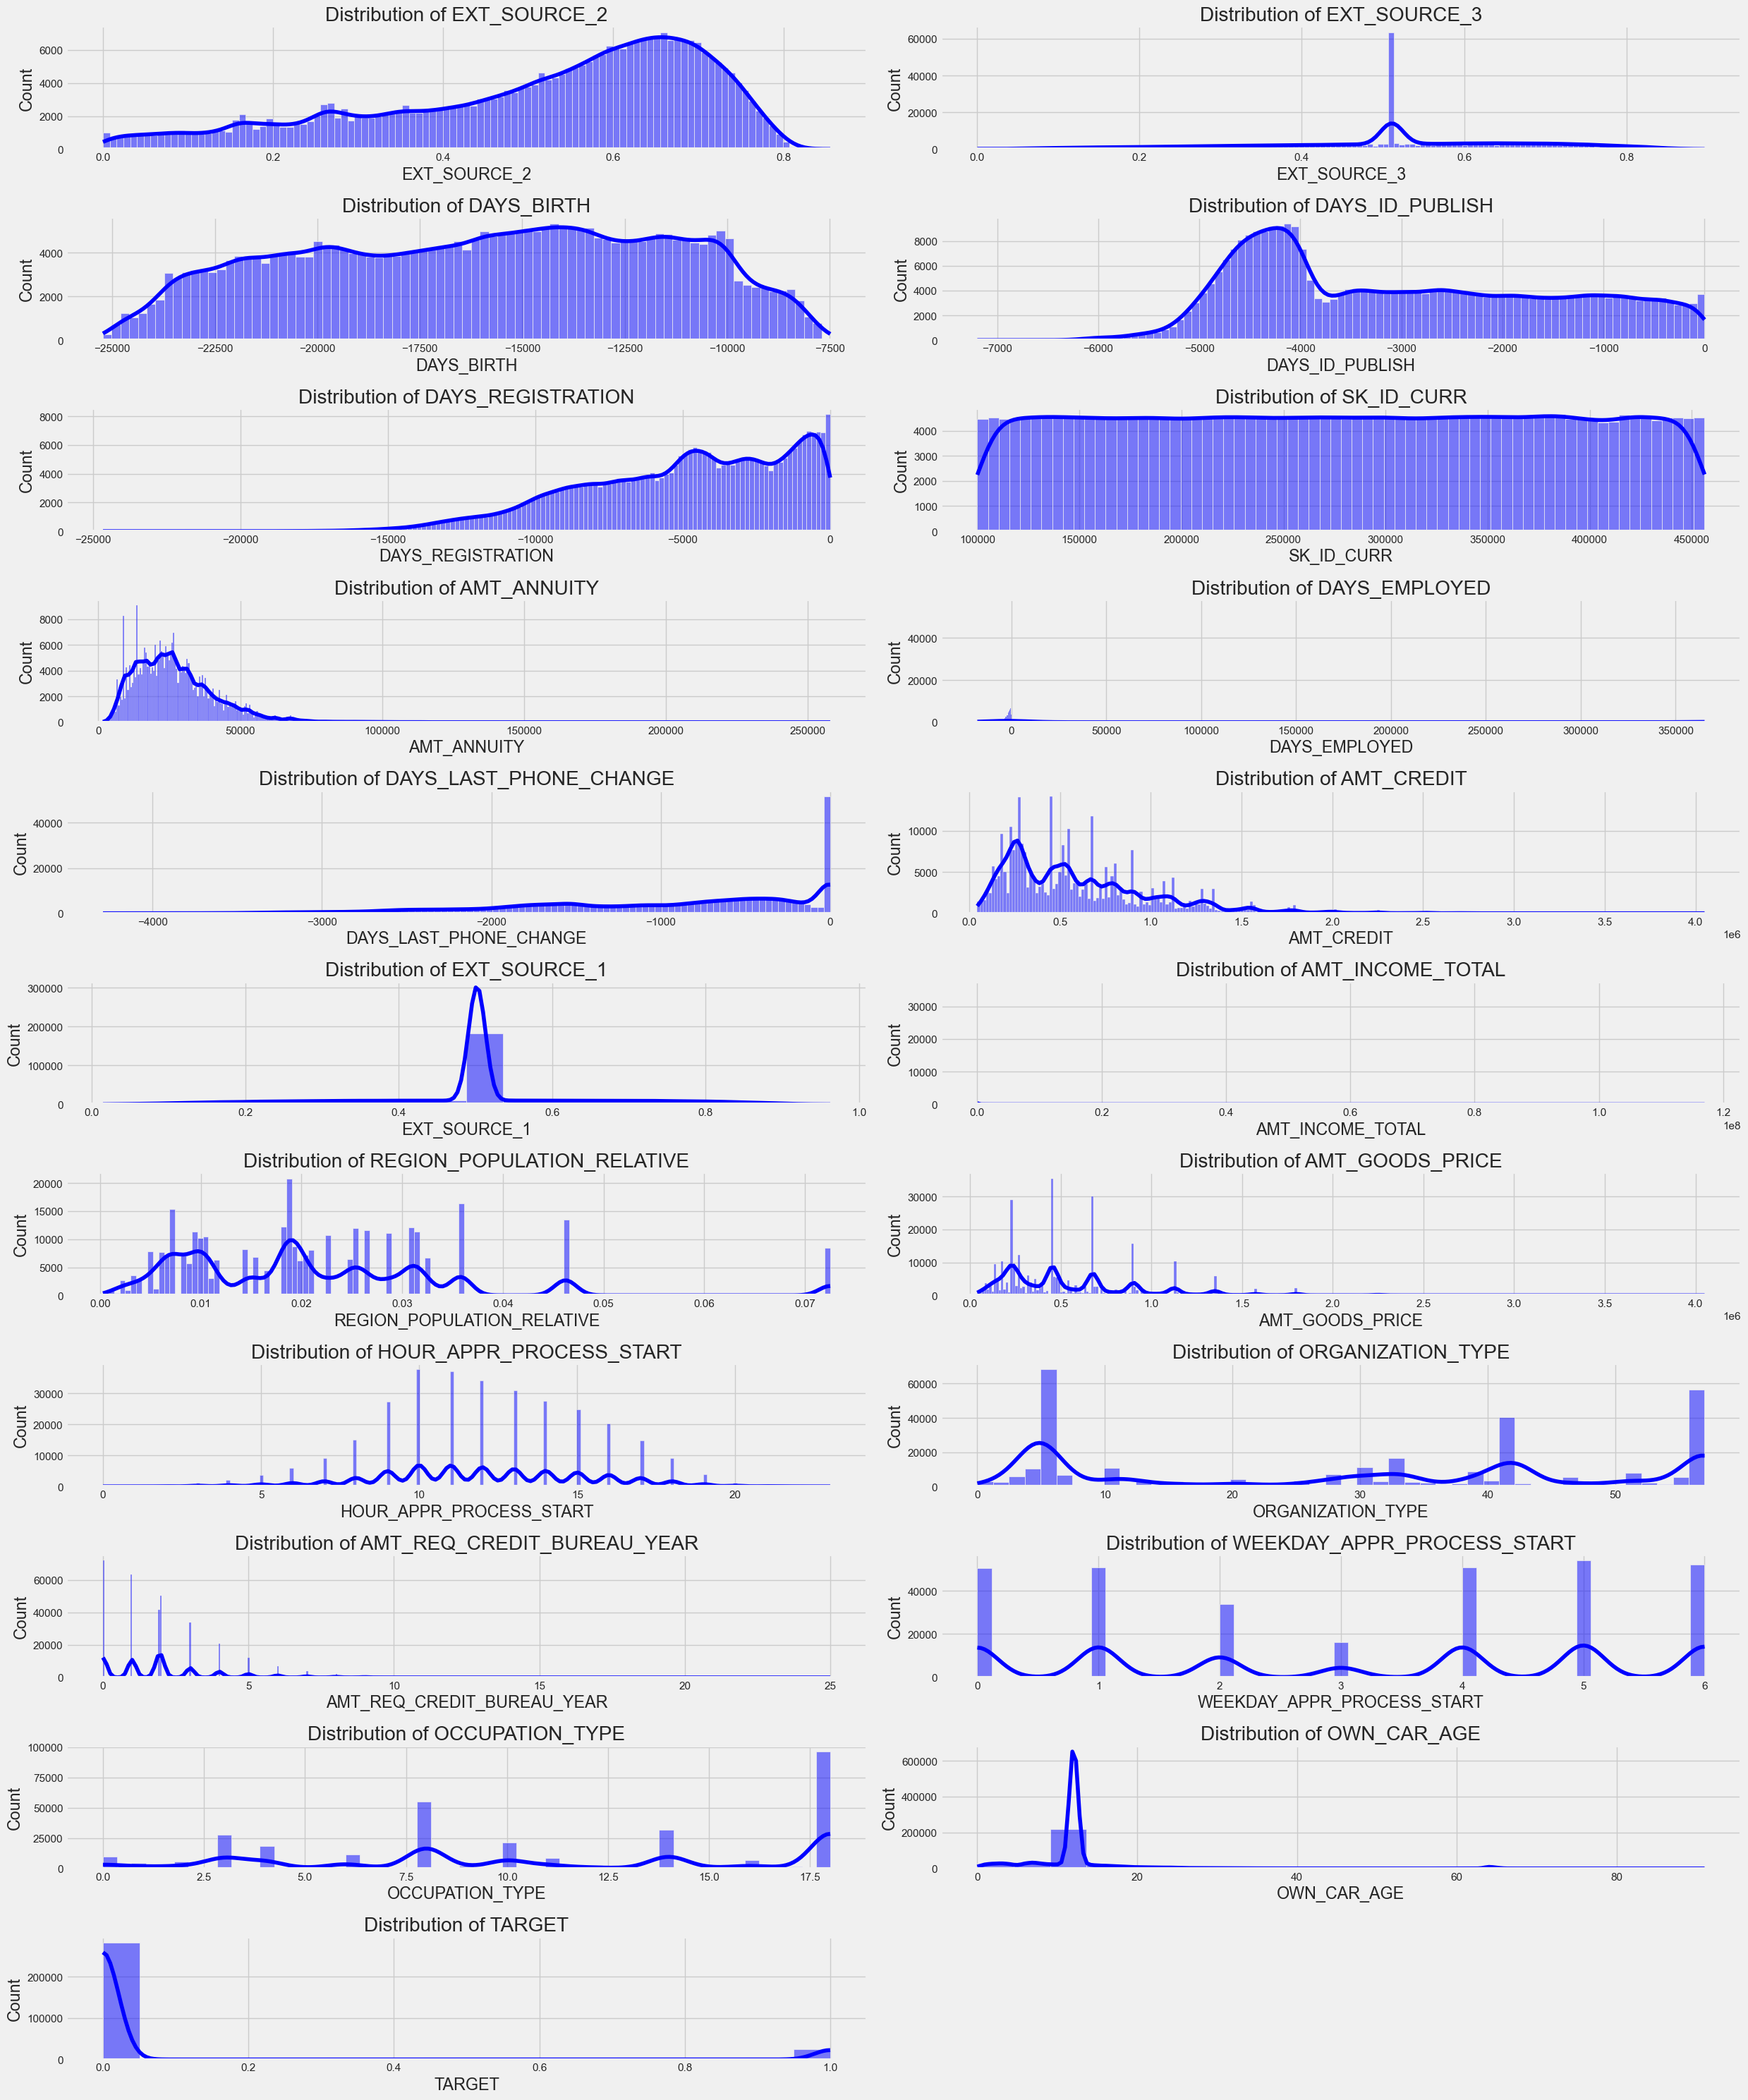

In [92]:
# Visualize distributions of numeric columns
plt.figure(figsize=(25, 30))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) // 2 + 1, 2, i + 1)
    sns.histplot(df_preprocess[column], kde=True, color='blue')
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()


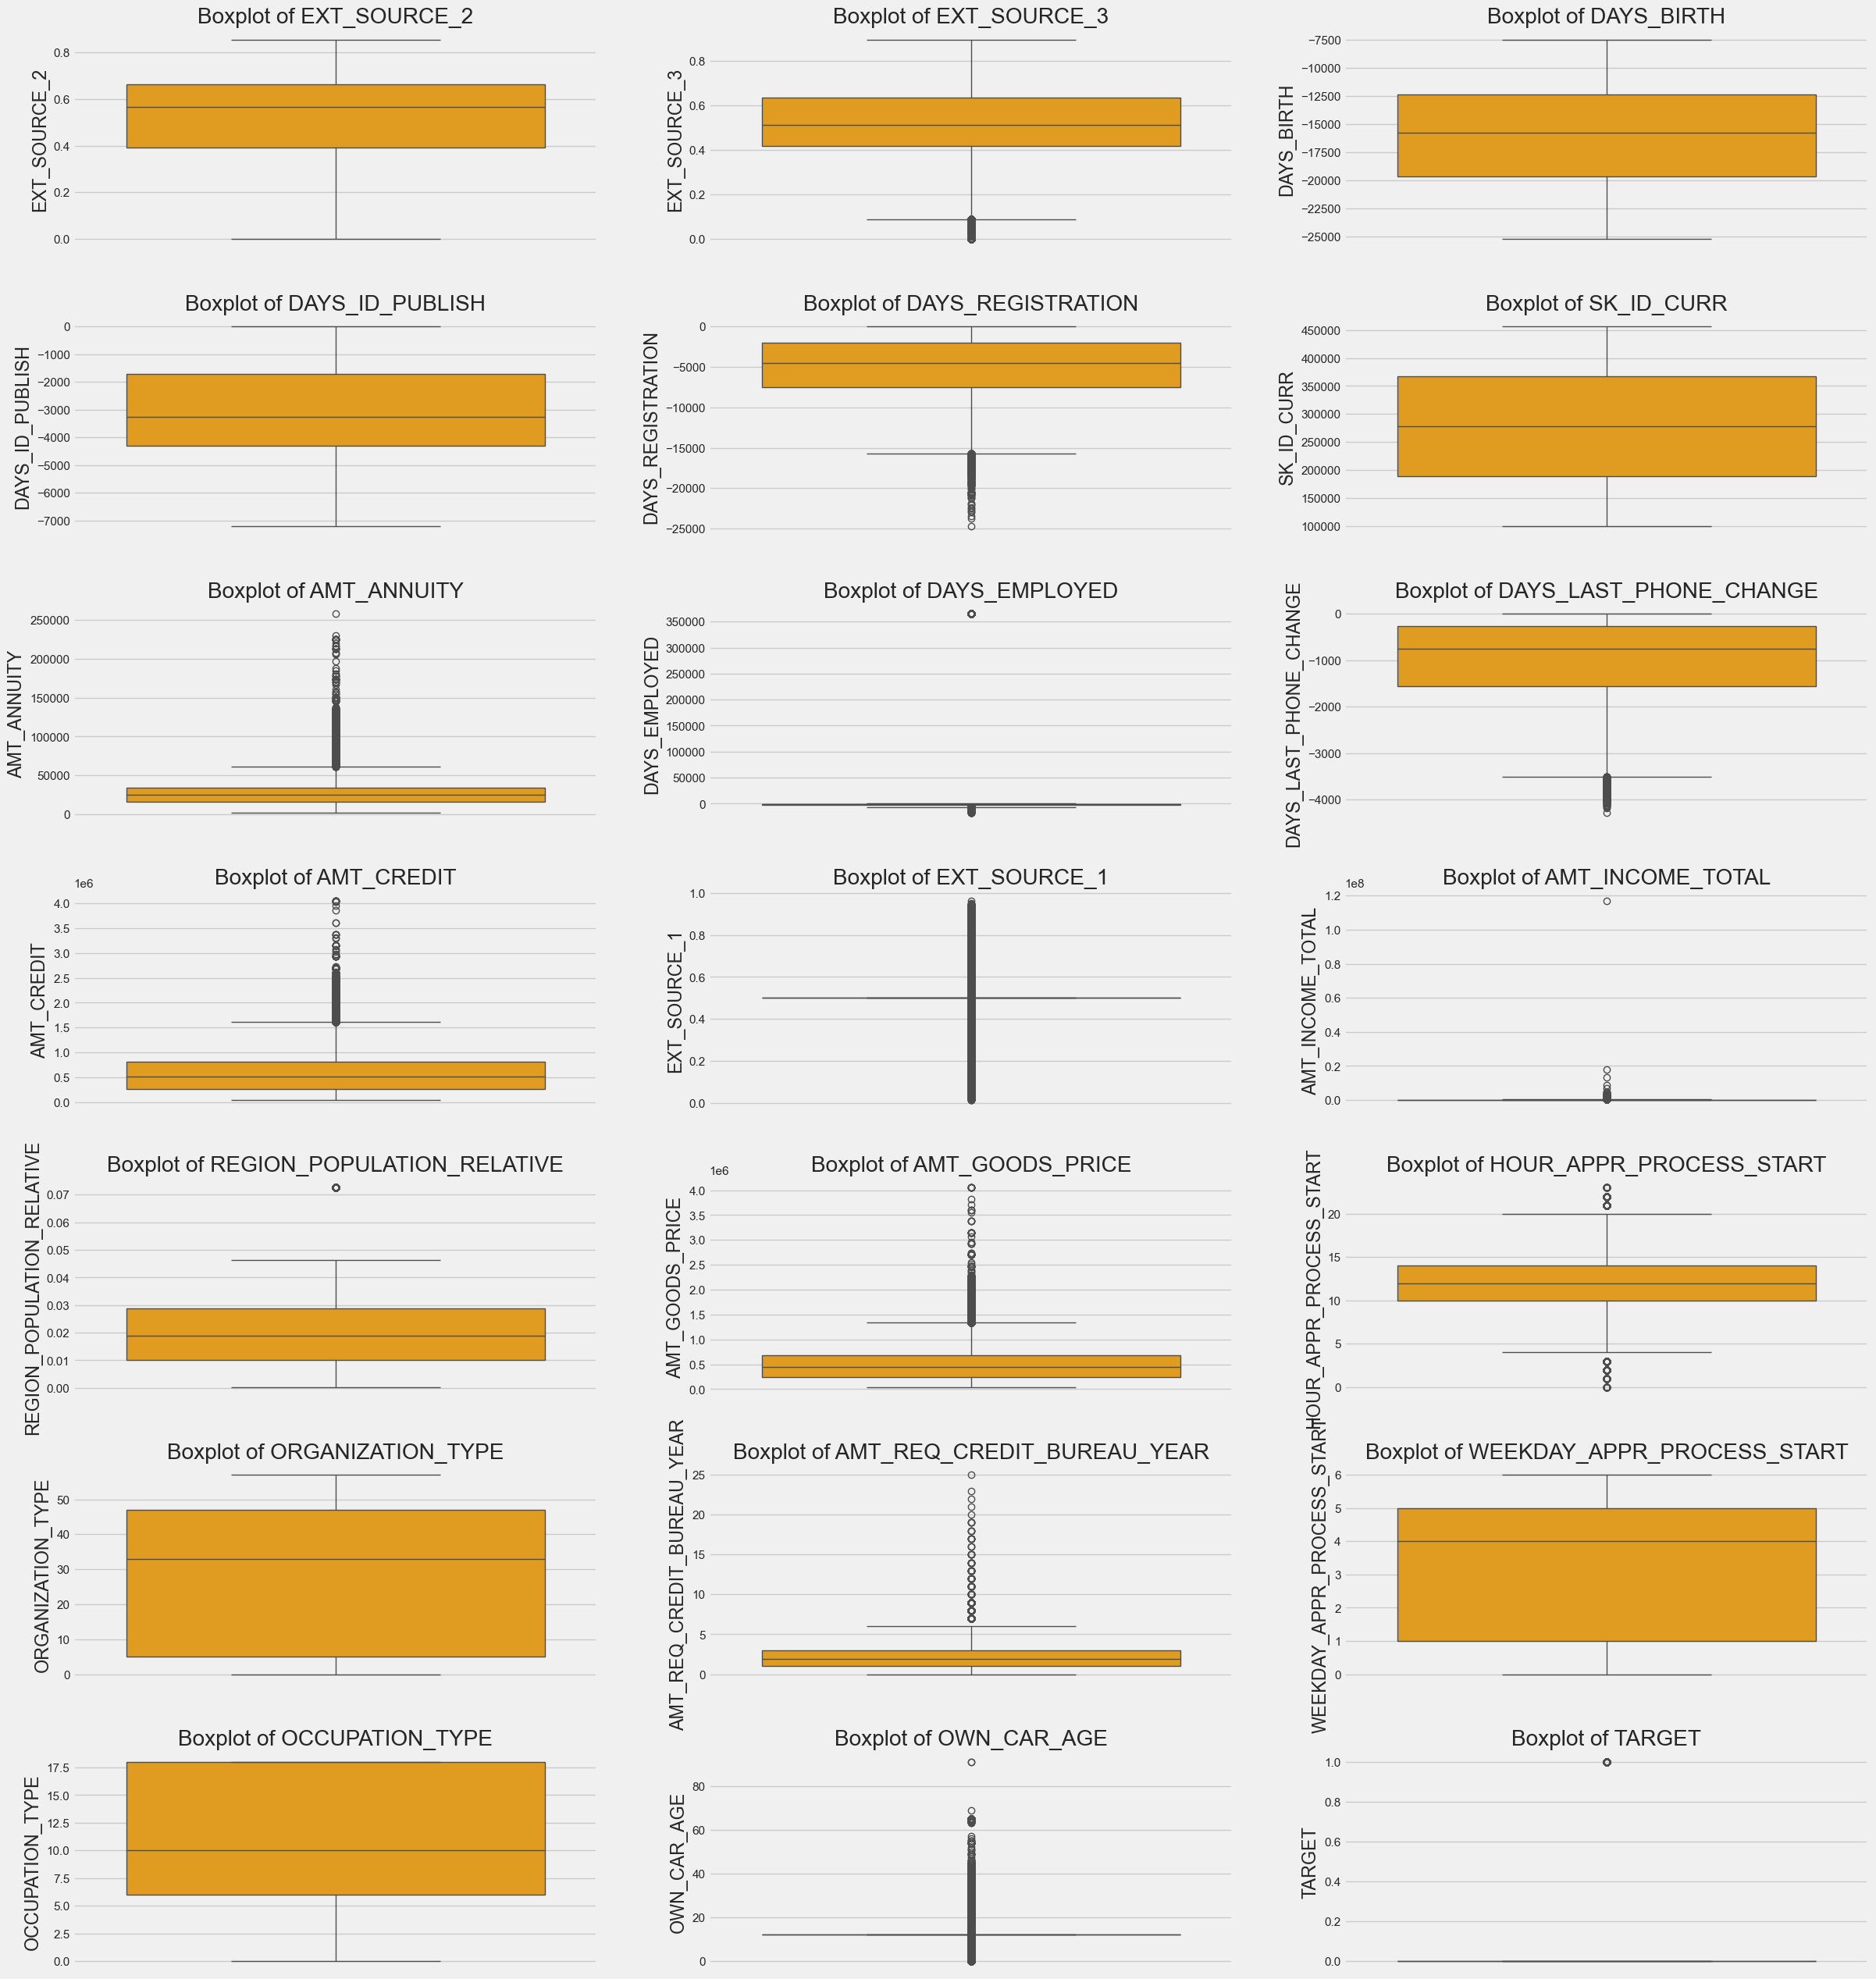

In [93]:
# Exploratory Data Analysis (EDA)

# Checking for outliers using boxplots for numeric columns
plt.figure(figsize=(25, 30))  # Increase figure size for better spacing
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i + 1)  # Use 3 columns layout for better spacing
    sns.boxplot(y=df_preprocess[column], orient='v', color='orange')
    plt.title(f'Boxplot of {column}')
    plt.tight_layout(pad=3)  # Increase padding for better spacing
plt.show()


**Multivariate Analysis**

---

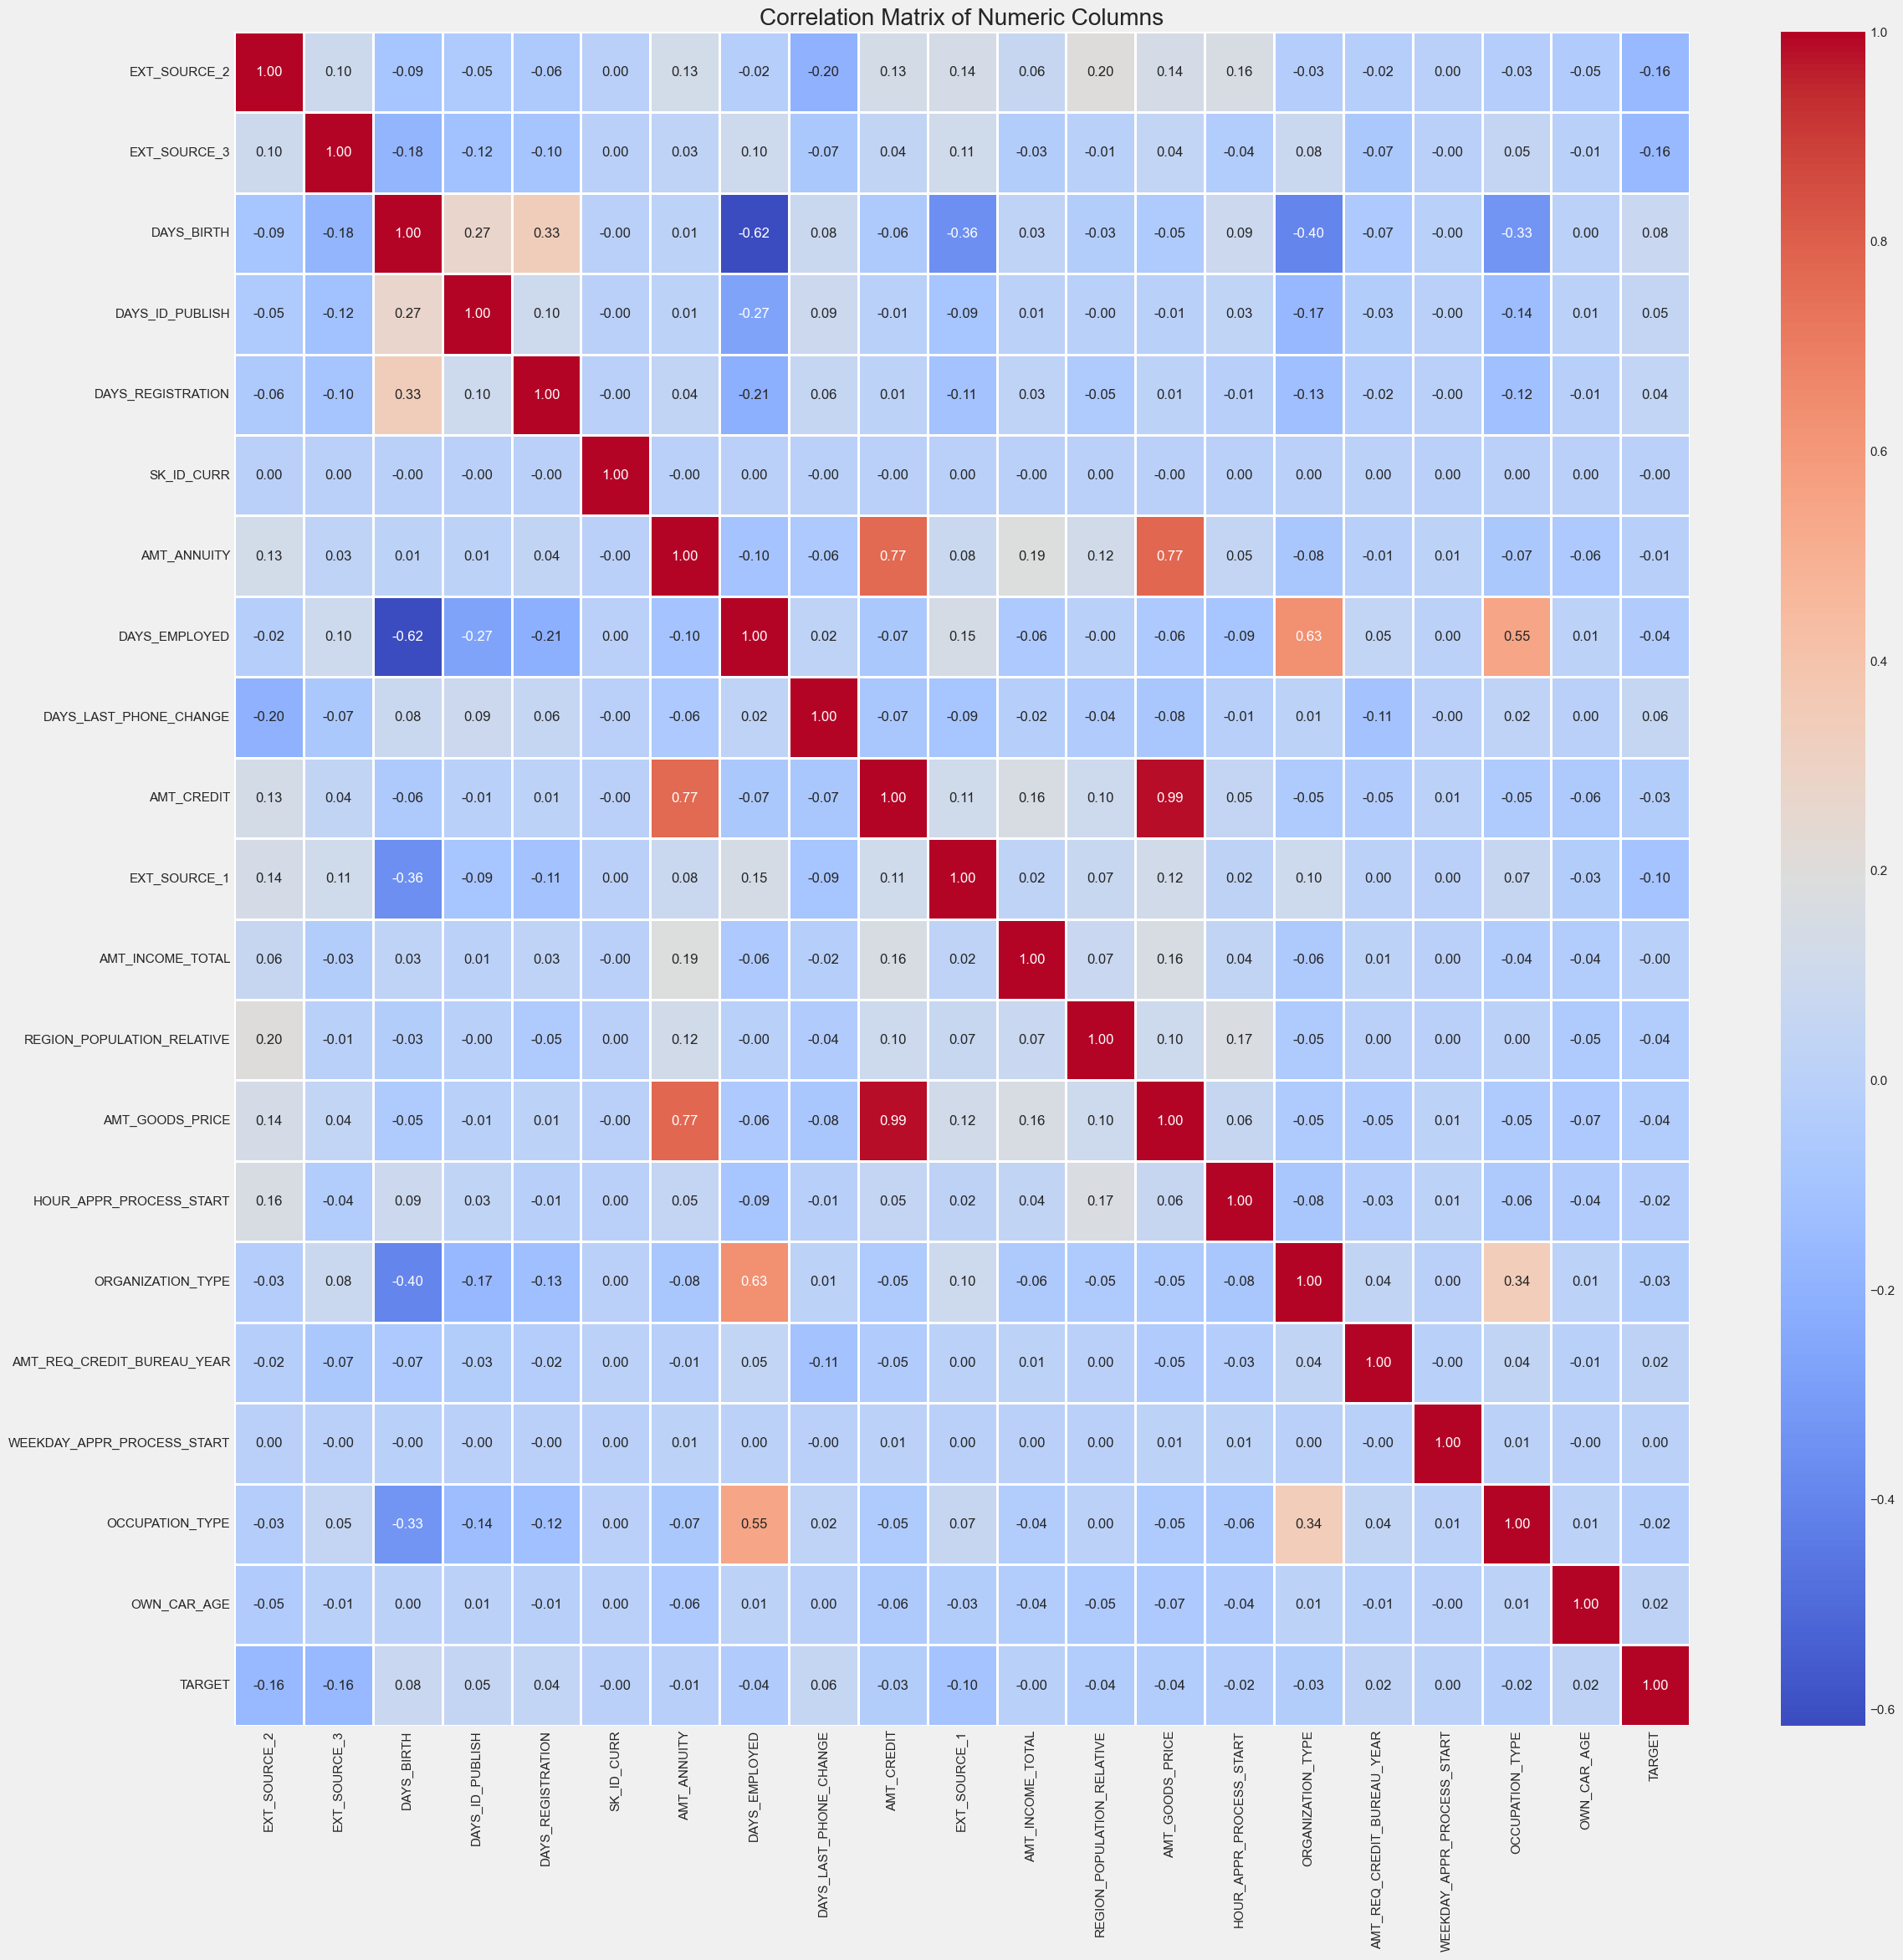

In [94]:
# Correlation matrix heatmap for numeric columns
plt.figure(figsize=(25, 25))
sns.heatmap(df_preprocess[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2, linecolor='white', annot_kws={'fontsize':12})
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [95]:
def redundan_feature(df_preprocess):
    corr_matrix = df_preprocess[numeric_columns].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    exclude_columns = ['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
    #[,'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_pymnt_amnt']
    
    for col in upper.columns:
        if any(upper[col] > 0.7) and col not in exclude_columns:
            df_preprocess.drop(col, axis=1, inplace=True)
            
    return df_preprocess

result = redundan_feature(df_preprocess)
print(result)


        EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  DAYS_ID_PUBLISH  \
0           0.262949      0.139376       -9461            -2120   
1           0.622246      0.510853      -16765             -291   
2           0.555912      0.729567      -19046            -2531   
3           0.650442      0.510853      -19005            -2437   
4           0.322738      0.510853      -19932            -3458   
...              ...           ...         ...              ...   
307506      0.681632      0.510853       -9327            -1982   
307507      0.115992      0.510853      -20775            -4090   
307508      0.535722      0.218859      -14966            -5150   
307509      0.514163      0.661024      -11961             -931   
307510      0.708569      0.113922      -16856             -410   

        DAYS_REGISTRATION  SK_ID_CURR  AMT_ANNUITY  DAYS_EMPLOYED  \
0                 -3648.0      100002      24700.5           -637   
1                 -1186.0      100003      35698.5       

**Check Categorical Features**

---

In [96]:
high_cardinality_threshold = 50
categorical_unique_counts = df_preprocess.select_dtypes(include='object').nunique()

def high_cardinality(df_preprocess):
    for col in categorical_unique_counts.index: #nunique() returns a Series with the column names as the index.
        if categorical_unique_counts[col] > high_cardinality_threshold:
            df_preprocess.drop(col, inplace=True)
    
    return df_preprocess

high_cardinality(df_preprocess)

def single_value(df_preprocess):    
    for col in categorical_unique_counts.index: #nunique() returns a Series with the column names as the index.
        if categorical_unique_counts[col] == 1:
            df_preprocess.drop(col, inplace=True)
    
    return df_preprocess

single_value(df_preprocess)

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,SK_ID_CURR,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,OWN_CAR_AGE,TARGET
0,0.262949,0.139376,-9461,-2120,-3648.0,100002,24700.5,-637,-1134.0,0.083037,202500.0,0.018801,10,5,1.000000,6,8,12.061091,1
1,0.622246,0.510853,-16765,-291,-1186.0,100003,35698.5,-1188,-828.0,0.311267,270000.0,0.003541,11,39,0.000000,1,3,12.061091,0
2,0.555912,0.729567,-19046,-2531,-4260.0,100004,6750.0,-225,-815.0,0.502130,67500.0,0.010032,9,11,0.000000,1,8,26.000000,0
3,0.650442,0.510853,-19005,-2437,-9833.0,100006,29686.5,-3039,-617.0,0.502130,135000.0,0.008019,17,5,1.899974,6,8,12.061091,0
4,0.322738,0.510853,-19932,-3458,-4311.0,100007,21865.5,-3038,-1106.0,0.502130,121500.0,0.028663,11,37,0.000000,4,3,12.061091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.681632,0.510853,-9327,-1982,-8456.0,456251,27558.0,-236,-273.0,0.145570,157500.0,0.032561,15,43,1.899974,4,14,12.061091,0
307507,0.115992,0.510853,-20775,-4090,-4388.0,456252,12001.5,365243,0.0,0.502130,72000.0,0.025164,8,57,1.899974,1,18,12.061091,0
307508,0.535722,0.218859,-14966,-5150,-6737.0,456253,29979.0,-7921,-1909.0,0.744026,153000.0,0.005002,9,39,1.000000,4,10,12.061091,0
307509,0.514163,0.661024,-11961,-931,-2562.0,456254,20205.0,-4786,-322.0,0.502130,171000.0,0.005313,9,3,0.000000,6,8,12.061091,1


**Check Numerical Features**

---

In [97]:
exclude_columns = ['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
numerical_unique_counts = df_preprocess.select_dtypes(exclude='object').nunique()

def high_cardinality_numeric(df_preprocess):

    for col in numerical_unique_counts.index: #nunique() returns a Series with the column names as the index.
        if numerical_unique_counts[col] > high_cardinality_threshold and col not in exclude_columns:
            df_preprocess.drop(col, axis=1, inplace=True)
    
    return df_preprocess
    
high_cardinality_numeric(df_preprocess)

,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,TARGET
0,-9461,-2120,-3648.0,-1134.0,10,1.000000,6,8,1
1,-16765,-291,-1186.0,-828.0,11,0.000000,1,3,0
2,-19046,-2531,-4260.0,-815.0,9,0.000000,1,8,0
3,-19005,-2437,-9833.0,-617.0,17,1.899974,6,8,0
4,-19932,-3458,-4311.0,-1106.0,11,0.000000,4,3,0
...,...,...,...,...,...,...,...,...,...
307506,-9327,-1982,-8456.0,-273.0,15,1.899974,4,14,0
307507,-20775,-4090,-4388.0,0.0,8,1.899974,1,18,0
307508,-14966,-5150,-6737.0,-1909.0,9,1.000000,4,10,0
307509,-11961,-931,-2562.0,-322.0,9,0.000000,6,8,1


In [98]:
def single_value_numeric(df_preprocess):
    
    for col in numerical_unique_counts.index: #nunique() returns a Series with the column names as the index.
        if numerical_unique_counts[col] == 1 and col not in exclude_columns:
            df_preprocess.drop(col, axis=1, inplace=True)
    
    return df_preprocess

single_value_numeric(df_preprocess)

,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,TARGET
0,-9461,-2120,-3648.0,-1134.0,10,1.000000,6,8,1
1,-16765,-291,-1186.0,-828.0,11,0.000000,1,3,0
2,-19046,-2531,-4260.0,-815.0,9,0.000000,1,8,0
3,-19005,-2437,-9833.0,-617.0,17,1.899974,6,8,0
4,-19932,-3458,-4311.0,-1106.0,11,0.000000,4,3,0
...,...,...,...,...,...,...,...,...,...
307506,-9327,-1982,-8456.0,-273.0,15,1.899974,4,14,0
307507,-20775,-4090,-4388.0,0.0,8,1.899974,1,18,0
307508,-14966,-5150,-6737.0,-1909.0,9,1.000000,4,10,0
307509,-11961,-931,-2562.0,-322.0,9,0.000000,6,8,1


## **Feature Engineering**

---

In [99]:
df_fe = df_preprocess.copy()

In [100]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DAYS_BIRTH                  307511 non-null  int64  
 1   DAYS_ID_PUBLISH             307511 non-null  int64  
 2   DAYS_REGISTRATION           307511 non-null  float64
 3   DAYS_LAST_PHONE_CHANGE      307511 non-null  float64
 4   HOUR_APPR_PROCESS_START     307511 non-null  int64  
 5   AMT_REQ_CREDIT_BUREAU_YEAR  307511 non-null  float64
 6   WEEKDAY_APPR_PROCESS_START  307511 non-null  int32  
 7   OCCUPATION_TYPE             307511 non-null  int32  
 8   TARGET                      307511 non-null  int64  
dtypes: float64(3), int32(2), int64(4)
memory usage: 18.8 MB


**Standardization**

In [101]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler
numerical_columns = df_fe.select_dtypes(include=['int64', 'int32', 'float64']).columns
numerical_columns_drop = numerical_columns.drop('TARGET')  # Exclude 'loan_status' from standardization
scaler = StandardScaler()
df_fe[numerical_columns_drop] = scaler.fit_transform(df_fe[numerical_columns_drop])

In [102]:
# df_fe_std = pd.concat([df_fe_encd, df_fe[numerical_columns]], axis=1)
df_fe_std = df_fe.copy()

In [103]:
df_fe_std.head()

,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,TARGET
0,1.506880,0.579154,0.379837,-0.206991,-0.631821,-5.176655e-01,1.353458,-0.509159,1
1,-0.166821,1.790855,1.078697,0.163108,-0.325620,-1.092866e+00,-0.972656,-1.348797,0
2,-0.689509,0.306869,0.206116,0.178831,-0.938022,-1.092866e+00,-0.972656,-0.509159,0
3,-0.680114,0.369143,-1.375829,0.418307,1.511587,-3.831603e-16,1.353458,-0.509159,0
4,-0.892535,-0.307263,0.191639,-0.173126,-0.325620,-1.092866e+00,0.423012,-1.348797,0


**New Features**

---

In [104]:
df_fe_std['AMT_REQ_CREDIT_BUREAU_MONTH'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12 # Rata-rata jumlah permintaan kredit per bulan.
df_fe_std['MONTHS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'] / 30 # Berapa lama sejak telepon terakhir diganti dalam bulan.
df_fe_std['MONTHS_REGISTRATION'] = df['DAYS_REGISTRATION'] / 30 # Lama pelanggan terdaftar dalam bulan.

In [105]:
numeric_columns = df_fe_std.select_dtypes(include=['number', 'int64', 'float64', 'int32']).columns.tolist()


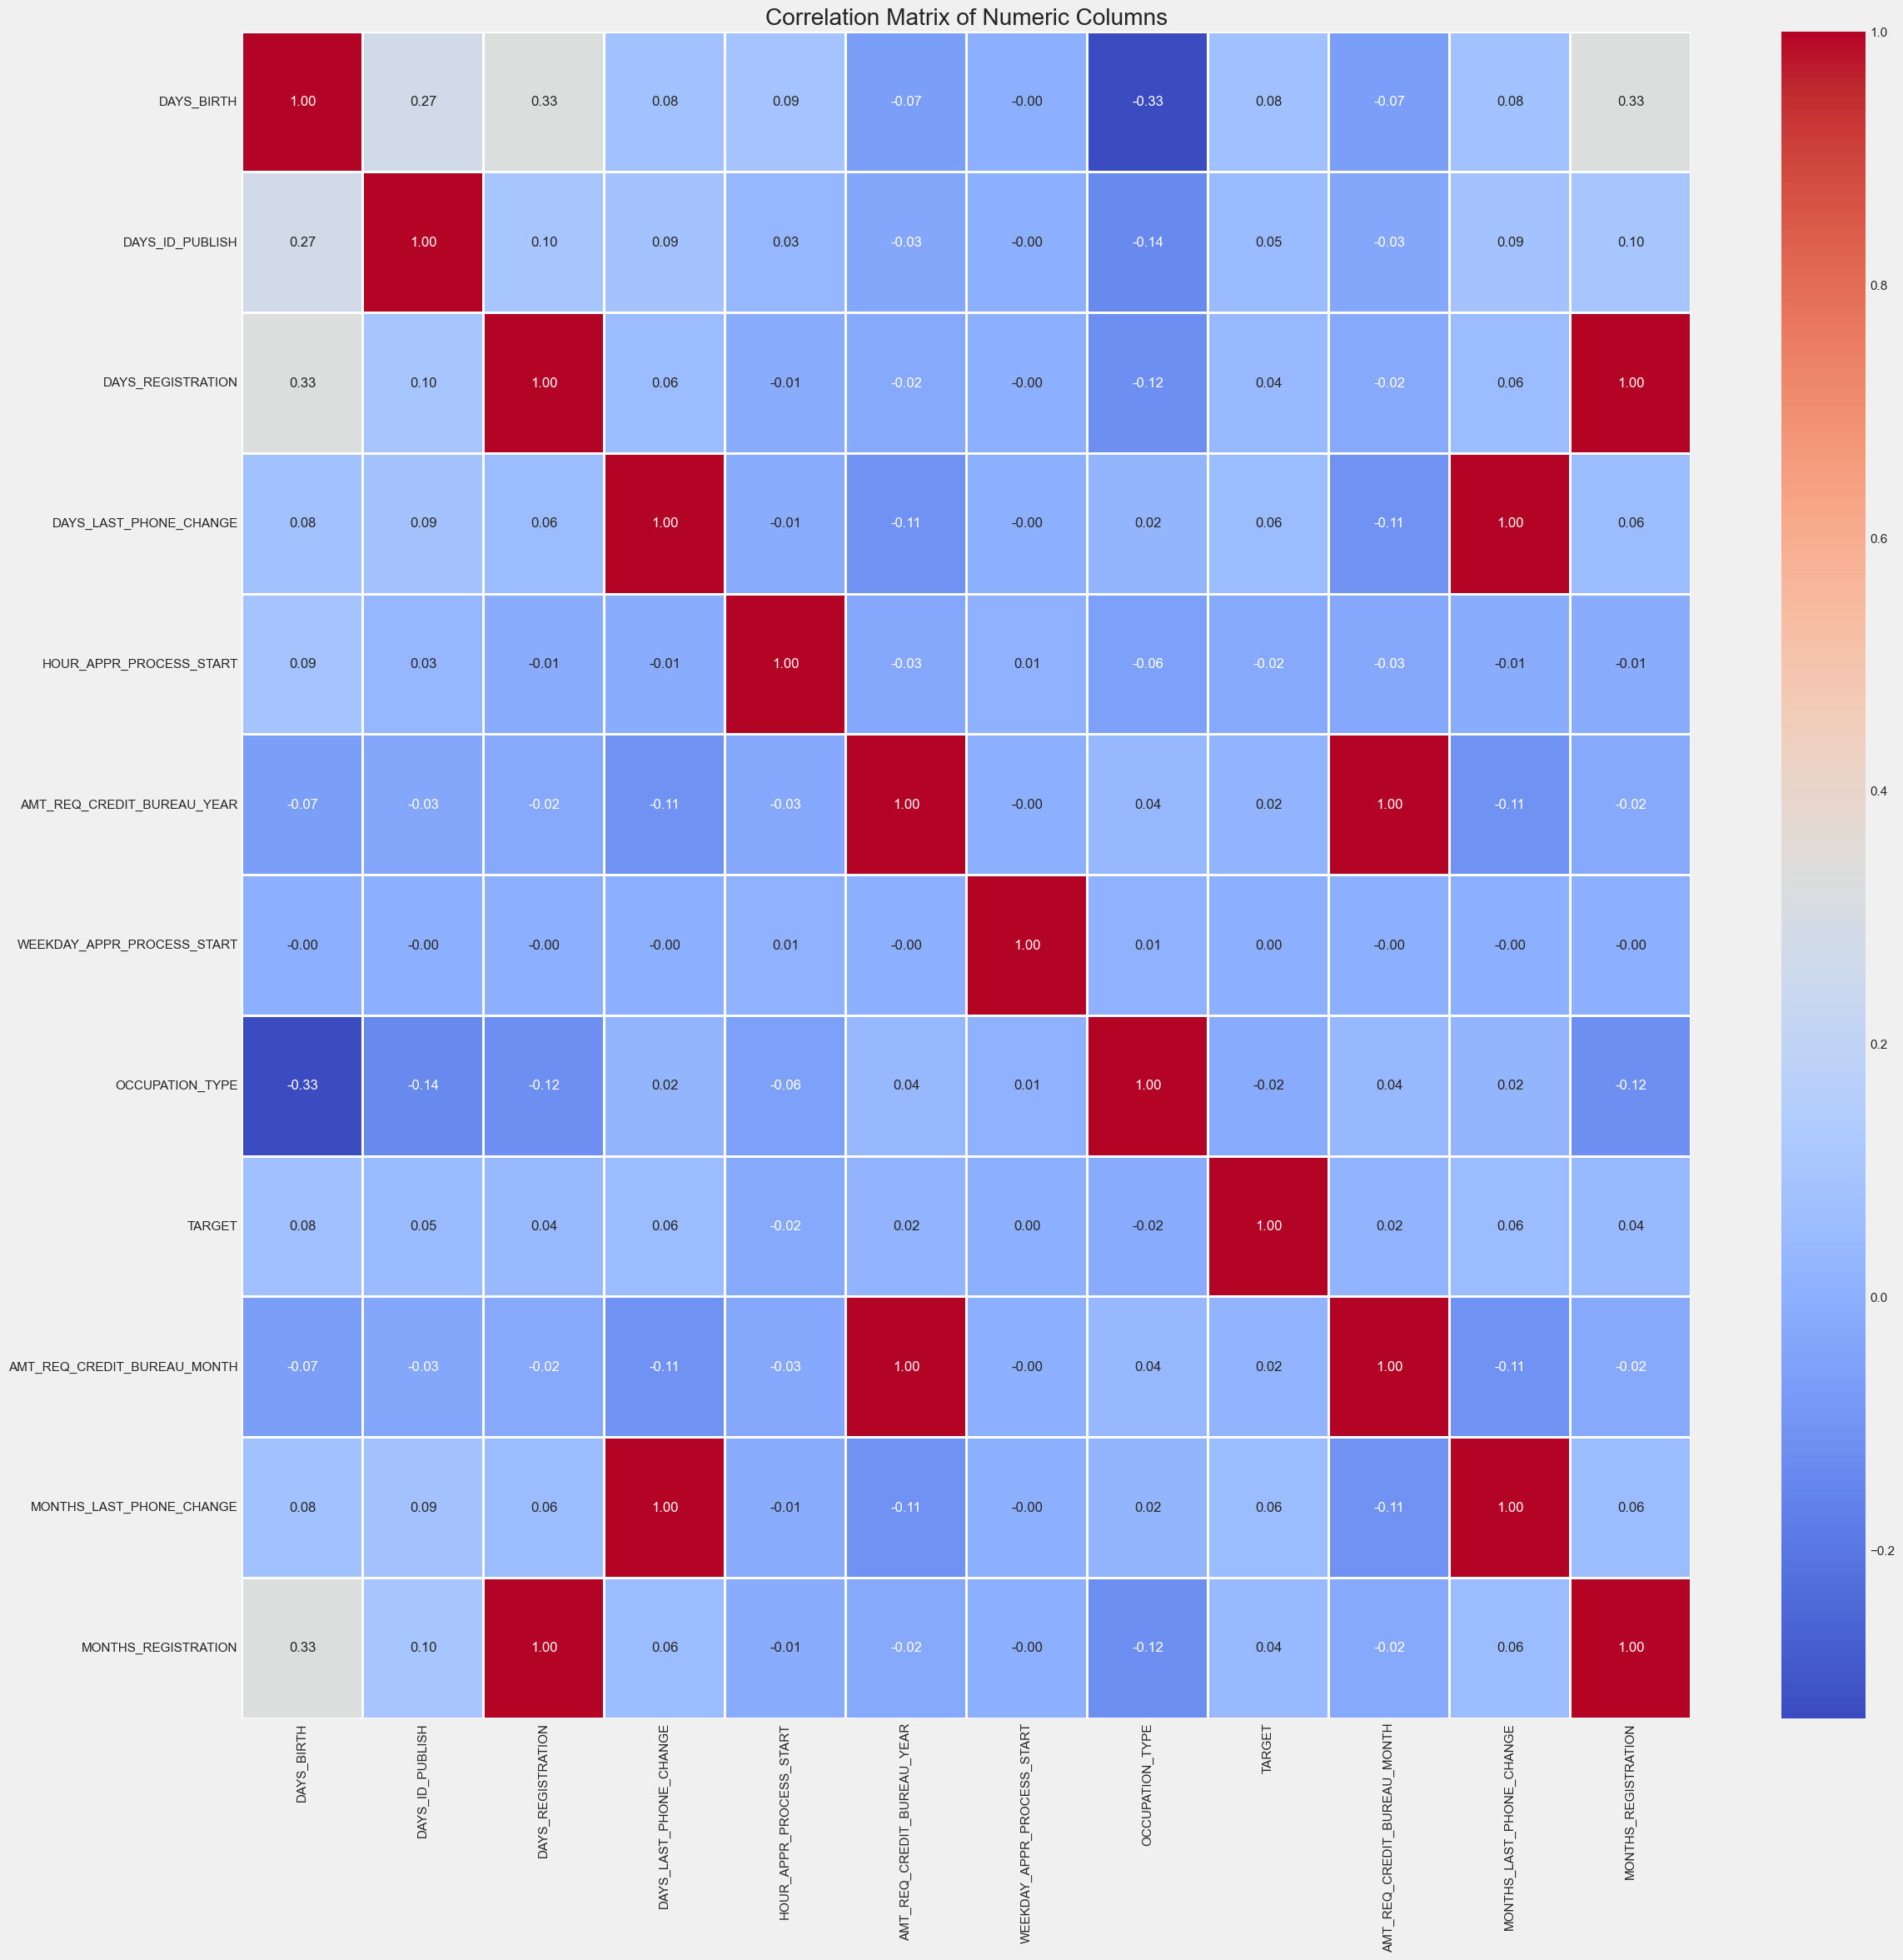

In [106]:
# Correlation matrix heatmap for numeric columns
plt.figure(figsize=(25, 25))
sns.heatmap(df_fe_std[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2, linecolor='white', annot_kws={'fontsize':12})
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

**Handling Outliers**

---

In [107]:

numerical_columns = df_fe_std.select_dtypes(include=['int64', 'int32', 'float64']).columns.drop('TARGET')

# Menghitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = df_fe_std[numerical_columns].quantile(0.25)
Q3 = df_fe_std[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas untuk outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mencari fitur yang memiliki outliers
outliers = ((df_fe_std[numerical_columns] < lower_bound) | (df_fe_std[numerical_columns] > upper_bound)).sum()
print(f"Fitur yang memiliki outliers:\n{outliers[outliers > 0]}")

# Mengatasi outliers dengan cara capping (membatasi) nilai outliers ke batas bawah dan batas atas
def cap_outliers(series):
    return np.where(series < lower_bound[series.name], lower_bound[series.name],
                    np.where(series > upper_bound[series.name], upper_bound[series.name], series))

# Menerapkan fungsi cap_outliers ke semua kolom numerikal
df_fe_std[numerical_columns] = df_fe_std[numerical_columns].apply(cap_outliers)

# Verifikasi perubahan
print("Outliers telah diatasi dengan capping ke batas bawah dan batas atas.")


Fitur yang memiliki outliers:
DAYS_REGISTRATION               659
DAYS_LAST_PHONE_CHANGE          435
HOUR_APPR_PROCESS_START        2257
AMT_REQ_CREDIT_BUREAU_YEAR     7233
AMT_REQ_CREDIT_BUREAU_MONTH    7233
MONTHS_LAST_PHONE_CHANGE        435
MONTHS_REGISTRATION             659
dtype: int64
Outliers telah diatasi dengan capping ke batas bawah dan batas atas.


In [108]:
df_modeling = df_fe_std.copy()

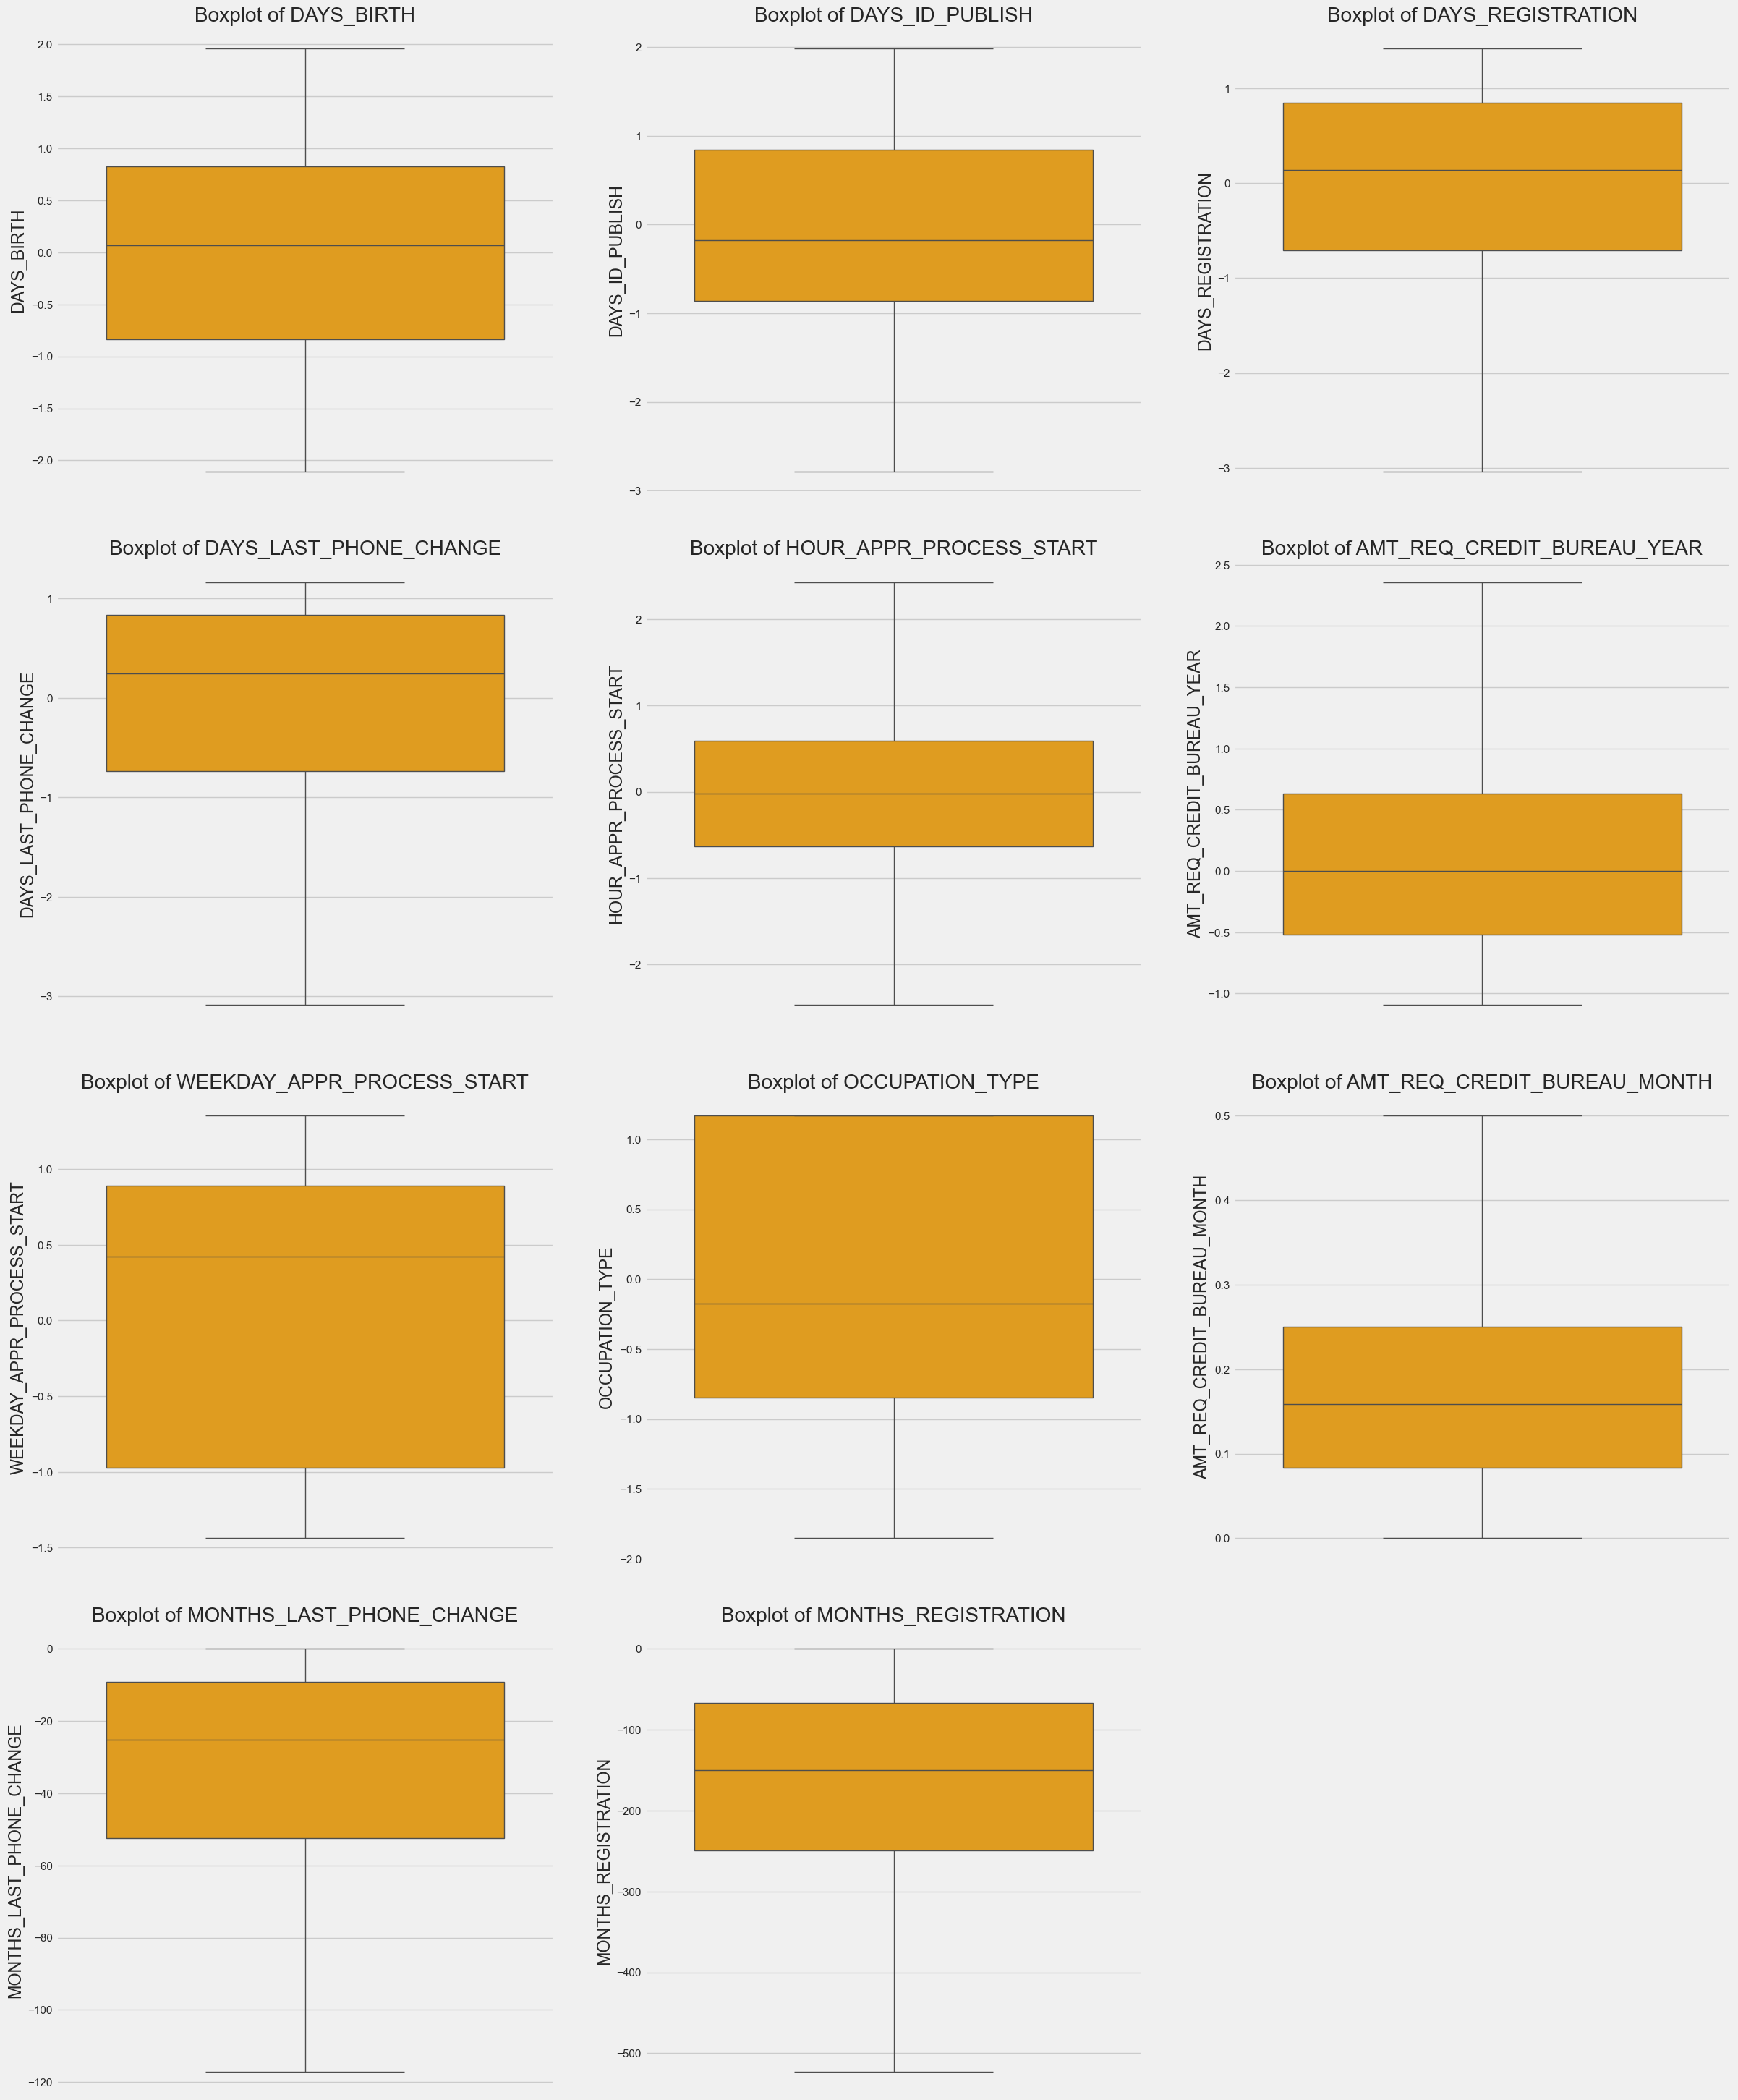

In [109]:
# Exploratory Data Analysis (EDA)

# Checking for outliers using boxplots for numeric columns
plt.figure(figsize=(25, 30))  # Increase figure size for better spacing
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i + 1)  # Use 3 columns layout for better spacing
    sns.boxplot(y=df_modeling[column], orient='v', color='orange')
    plt.title(f'Boxplot of {column}')
    plt.tight_layout(pad=3)  # Increase padding for better spacing
plt.show()


# **Modeling**

---

In [110]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DAYS_BIRTH                   307511 non-null  float64
 1   DAYS_ID_PUBLISH              307511 non-null  float64
 2   DAYS_REGISTRATION            307511 non-null  float64
 3   DAYS_LAST_PHONE_CHANGE       307511 non-null  float64
 4   HOUR_APPR_PROCESS_START      307511 non-null  float64
 5   AMT_REQ_CREDIT_BUREAU_YEAR   307511 non-null  float64
 6   WEEKDAY_APPR_PROCESS_START   307511 non-null  float64
 7   OCCUPATION_TYPE              307511 non-null  float64
 8   TARGET                       307511 non-null  int64  
 9   AMT_REQ_CREDIT_BUREAU_MONTH  307511 non-null  float64
 10  MONTHS_LAST_PHONE_CHANGE     307511 non-null  float64
 11  MONTHS_REGISTRATION          307511 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 28.2 MB


In [111]:
# Memisahkan fitur dan target
# , 'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'WEEKDAY_APPR_PROCESS_START', 'OCCUPATION_TYPE'
X = df_modeling.drop(columns=['TARGET', 'HOUR_APPR_PROCESS_START', 'OCCUPATION_TYPE'])
y = df_modeling['TARGET']

Drop kolom yang tidak diperlukan atau kolom yang tidak terlalu berpengaruh pada performa model. Jadi kolom yang di drop diatas tidak semata-mata dipilih begitu saja, saya sudah berkali-kali menguji performa model dan melihat beberapa feature yang tidak terlalu berpengaruh terhadap performa model.

**Split Data and Class Imbalance**

---

In [112]:
df_modeling['TARGET'].value_counts(normalize=True)*100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

In [113]:
# Mengatasi class imbalance pada fitur target 'loan_status' menggunakan SMOTE
from imblearn.over_sampling import SMOTE

# Pastikan y adalah tipe data kategorikal
y = y.astype('int')

# Periksa distribusi kelas pada target
print("Distribusi kelas sebelum SMOTE:")
print(y.value_counts())

# Pastikan y memiliki lebih dari satu kelas
if len(y.unique()) > 1:
    # Menggunakan SMOTE untuk oversampling
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Menggabungkan kembali fitur dan target ke dalam dataframe
    df_fe_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Menampilkan distribusi kelas setelah resampling
    print("Distribusi kelas setelah SMOTE:")
    print(df_fe_resampled['TARGET'].value_counts(normalize=True) * 100)
else:
    print("Target 'y' hanya memiliki satu kelas. Tidak dapat menerapkan SMOTE.")

Distribusi kelas sebelum SMOTE:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Distribusi kelas setelah SMOTE:
TARGET
1    50.0
0    50.0
Name: proportion, dtype: float64


In [114]:
from sklearn.model_selection import train_test_split

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Menampilkan ukuran data setelah split
print("Ukuran data train:", X_train.shape)
print("Ukuran data test:", X_test.shape)


Ukuran data train: (452297, 9)
Ukuran data test: (113075, 9)


In [115]:
# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Replace any invalid characters in column names
X_train.columns = X_train.columns.str.replace('[\[\]<]', '', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<]', '', regex=True)

In [116]:
def eval_classification(model):
    y_pred = model.predict(X_test.values)
    y_pred_train = model.predict(X_train.values)
    y_pred_proba = model.predict_proba(X_test.values)
    y_pred_proba_train = model.predict_proba(X_train.values)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    score = cross_validate(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

lg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
grd = GradientBoostingClassifier(random_state=42)

# **FIT MODELS**

### **Fit Model - Logistic Regression**

---

In [117]:
lgmodel = lg.fit(X_train, y_train)
eval_classification(lgmodel)

Accuracy (Test Set): 0.58
Accuracy (Train Set): 0.59
Precision (Test Set): 0.58
Precision (Train Set): 0.58
Recall (Test Set): 0.60
Recall (Train Set): 0.60
F1-Score (Test Set): 0.59
F1-Score (Train Set): 0.59
roc_auc (test-proba): 0.61
roc_auc (train-proba): 0.61
roc_auc (crossval train): 0.9999999625722126
roc_auc (crossval test): 0.567715181015317


In [118]:
y_pred_lg_prob = lgmodel.predict_proba(X_test)[:,1]
y_pred_lg = lgmodel.predict(X_test)

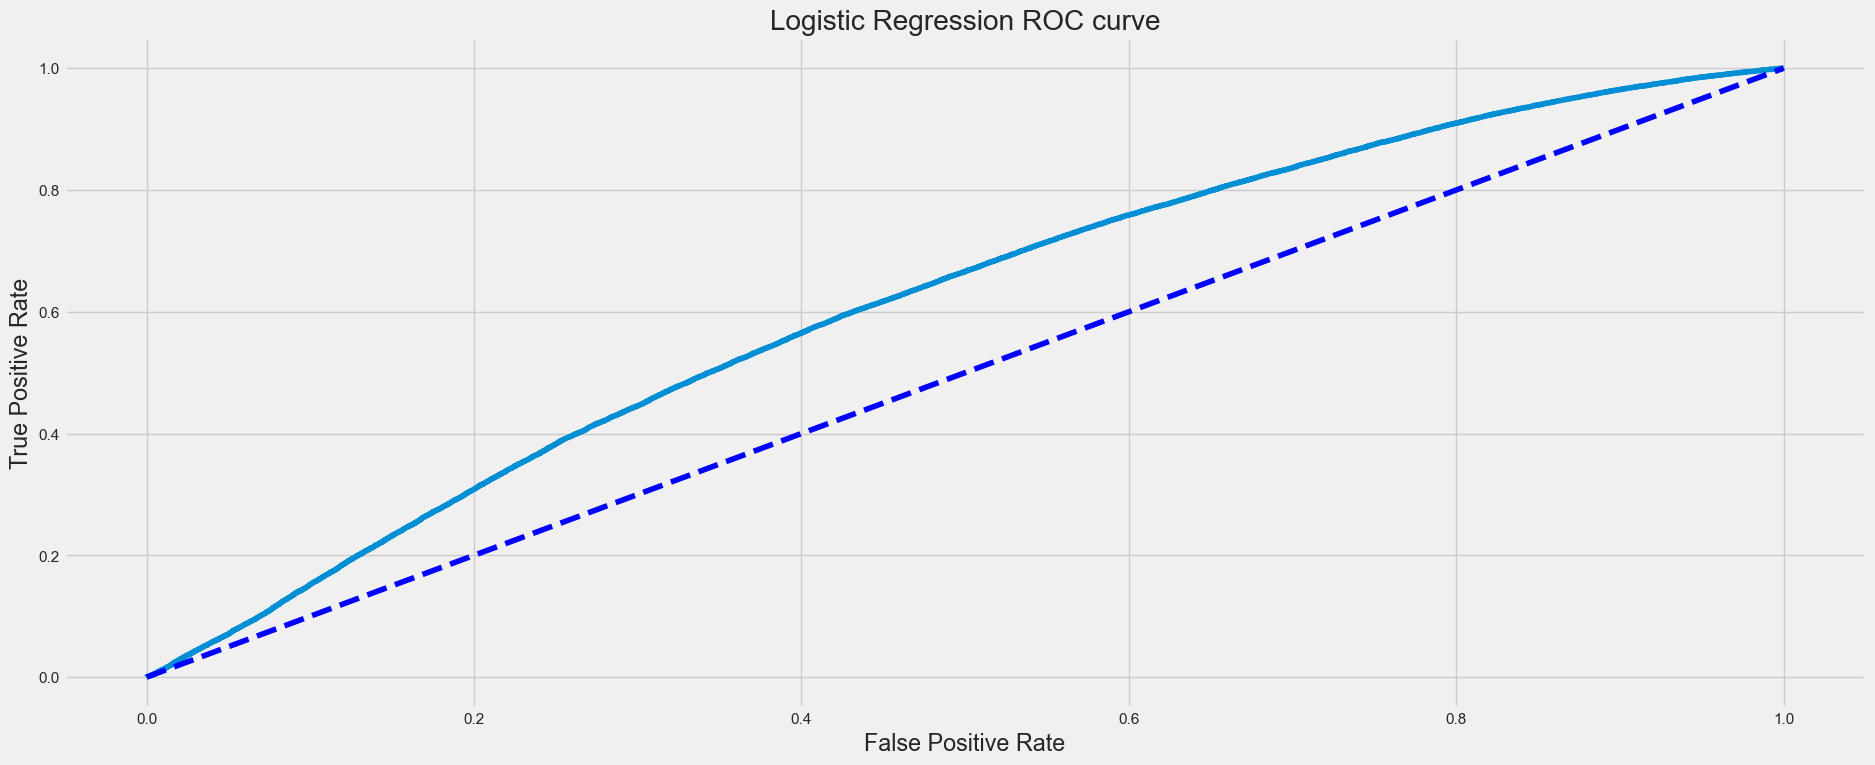

In [119]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lg_prob)
plt.title('Logistic Regression ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[32350 24186]
 [22672 33867]]



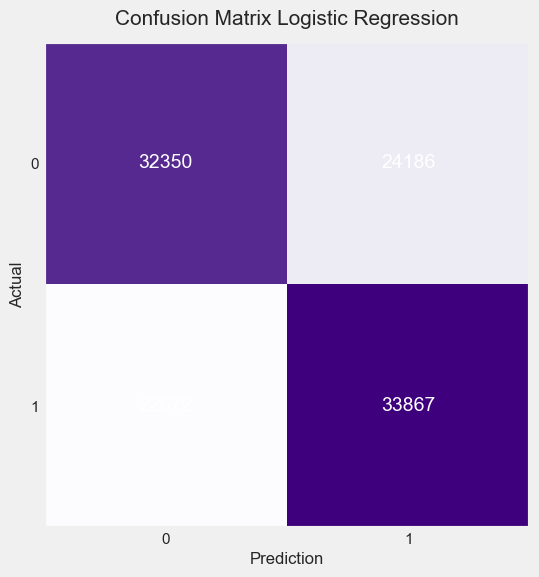

In [41]:
cmlg = confusion_matrix(y_test, y_pred_lg)
print(cmlg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlg, figsize=(6, 6), cmap=plt.cm.Purples)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Logistic Regression', fontsize=15, pad=12)
plt.show()

### Hyperparameter Tuning

In [246]:
parameter = {'C': [float(x) for x in np.linspace(0.0001, 0.05, 100)],'penalty':['l2','l1', 'elasticnet']}
lgmodel2 = GridSearchCV(lg, parameter, cv = 3, n_jobs = -1 , verbose = 1, scoring = 'accuracy')
lgmodel2.fit(X_train, y_train)
lgmodelbest = lgmodel2.best_estimator_
y_pred_lg2 = lgmodelbest.predict(X_test)
y_pred_lg2_prob= lgmodelbest.predict_proba(X_test)[:,1]
eval_classification(lgmodelbest)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


Accuracy (Test Set): 0.49
Accuracy (Train Set): 0.49
Precision (Test Set): 0.00
Precision (Train Set): 0.00
Recall (Test Set): 0.00
Recall (Train Set): 0.00
F1-Score (Test Set): 0.00
F1-Score (Train Set): 0.00
roc_auc (test-proba): 0.51
roc_auc (train-proba): 0.51
roc_auc (crossval train): 0.9999999998236154
roc_auc (crossval test): 0.8897389293545054


### **K-Nearest Neighbor**

---

In [42]:
knnmodel = knn.fit(X_train, y_train)
eval_classification(knnmodel)

Accuracy (Test Set): 0.84
Accuracy (Train Set): 0.89
Precision (Test Set): 0.76
Precision (Train Set): 0.82
Recall (Test Set): 1.00
Recall (Train Set): 1.00
F1-Score (Test Set): 0.86
F1-Score (Train Set): 0.90
roc_auc (test-proba): 0.95
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.9999999324473168
roc_auc (crossval test): 0.5888632879513741


In [43]:
y_pred_knn_prob = knnmodel.predict_proba(X_test)[:,1]
y_pred_knn = knnmodel.predict(X_test)

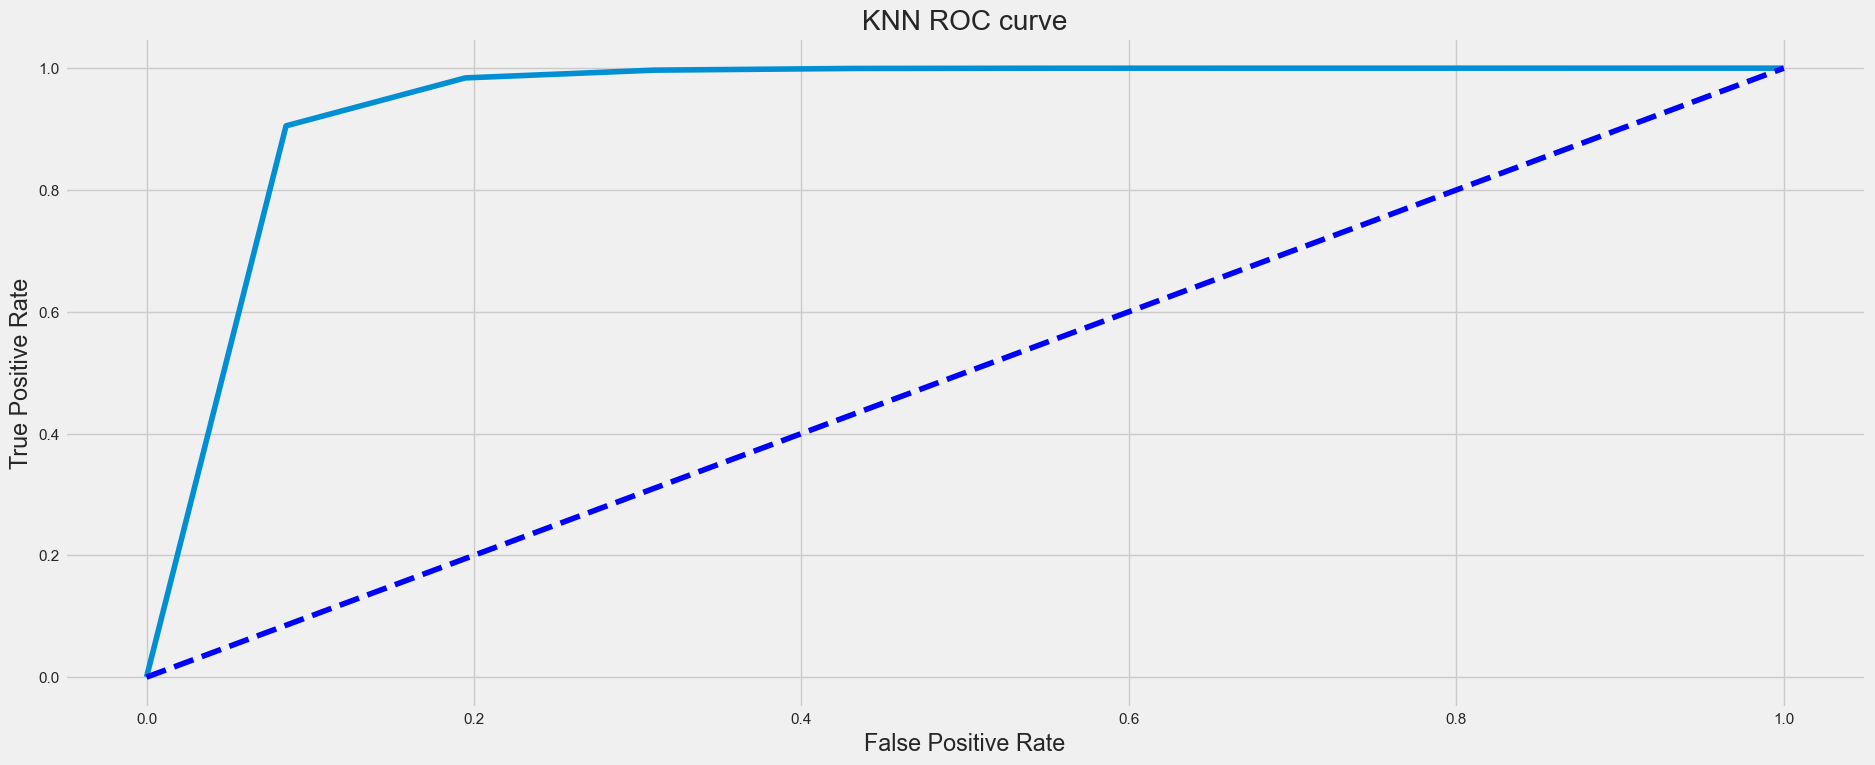

In [44]:
falposr, truposr, _ = roc_curve(y_test, y_pred_knn_prob)
plt.title('KNN ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[39022 17514]
 [  186 56353]]



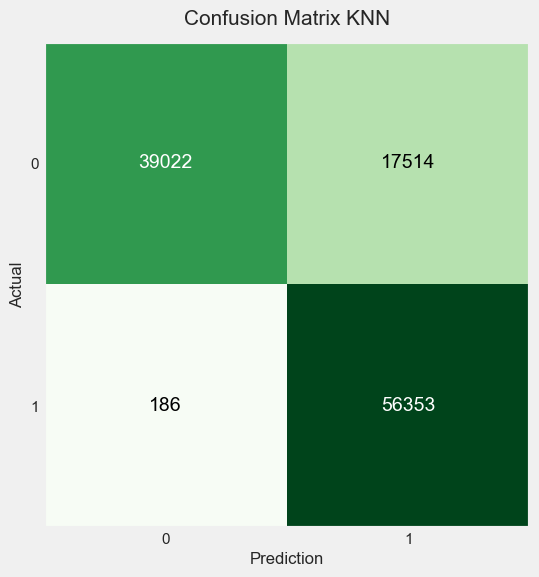

In [45]:
cmknn = confusion_matrix(y_test, y_pred_knn)
print(cmknn)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmknn, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix KNN', fontsize=15, pad=12)
plt.show()

### Hyperparameter Tuning

In [251]:
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

knnmodel = knn.fit(X_train, y_train)
knnrs = RandomizedSearchCV(knnmodel, hyperparameters, scoring='accuracy', random_state=99, cv=5)
knnrs.fit(X_train, y_train)
knnmodelbest = knnrs.best_estimator_
eval_classification(knnmodelbest)

Accuracy (Test Set): 0.76
Accuracy (Train Set): 0.87
Precision (Test Set): 0.87
Precision (Train Set): 1.00
Recall (Test Set): 0.61
Recall (Train Set): 0.75
F1-Score (Test Set): 0.72
F1-Score (Train Set): 0.86
roc_auc (test-proba): 0.79
roc_auc (train-proba): 0.97
roc_auc (crossval train): 0.9999999998992088
roc_auc (crossval test): 0.8898974458050816


### **Decision Tree**

---

In [46]:
dtmodel = dt.fit(X_train, y_train)
eval_classification(dtmodel)

Accuracy (Test Set): 0.89
Accuracy (Train Set): 1.00
Precision (Test Set): 0.87
Precision (Train Set): 1.00
Recall (Test Set): 0.90
Recall (Train Set): 1.00
F1-Score (Test Set): 0.89
F1-Score (Train Set): 1.00
roc_auc (test-proba): 0.89
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.9999999631065799
roc_auc (crossval test): 0.5889701169140201


In [47]:
y_pred_dt_prob = dtmodel.predict_proba(X_test)[:,1]
y_pred_dt = dtmodel.predict(X_test)

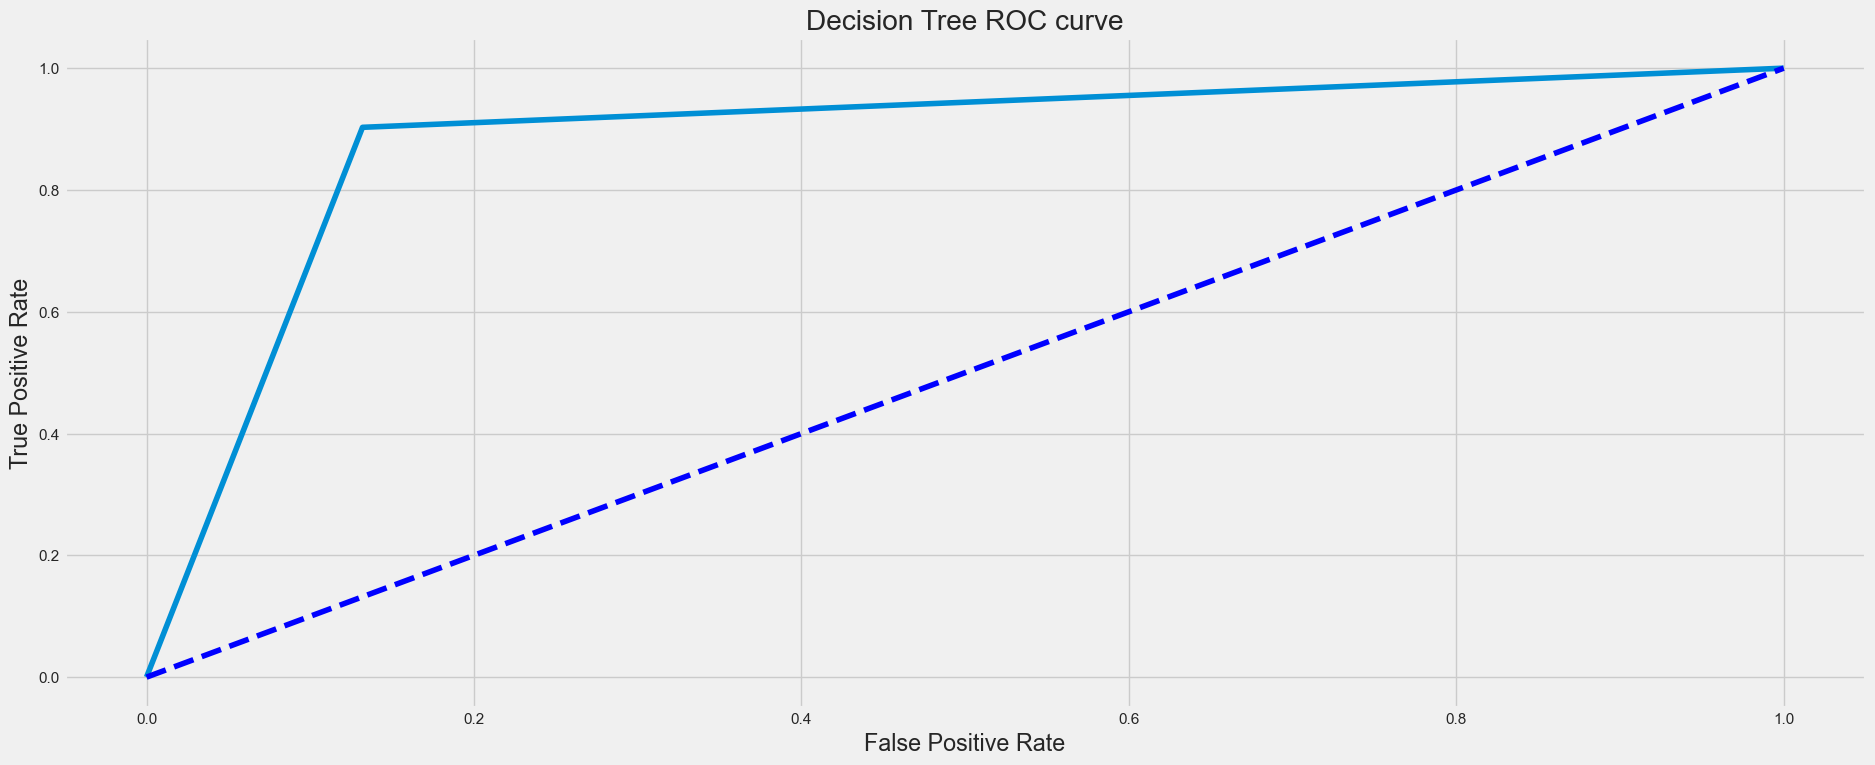

In [48]:
falposr, truposr, _ = roc_curve(y_test, y_pred_dt_prob)
plt.title('Decision Tree ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[49078  7458]
 [ 5496 51043]]



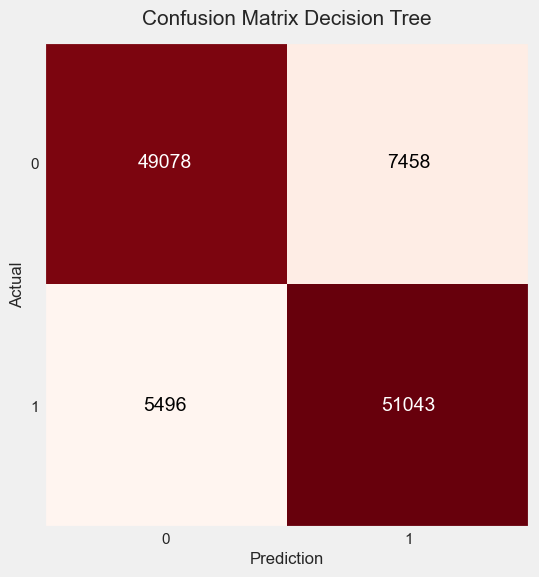

In [49]:
cmdt = confusion_matrix(y_test, y_pred_dt)
print(cmdt)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmdt, figsize=(6, 6), cmap=plt.cm.Reds)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Decision Tree', fontsize=15, pad=12)
plt.show()

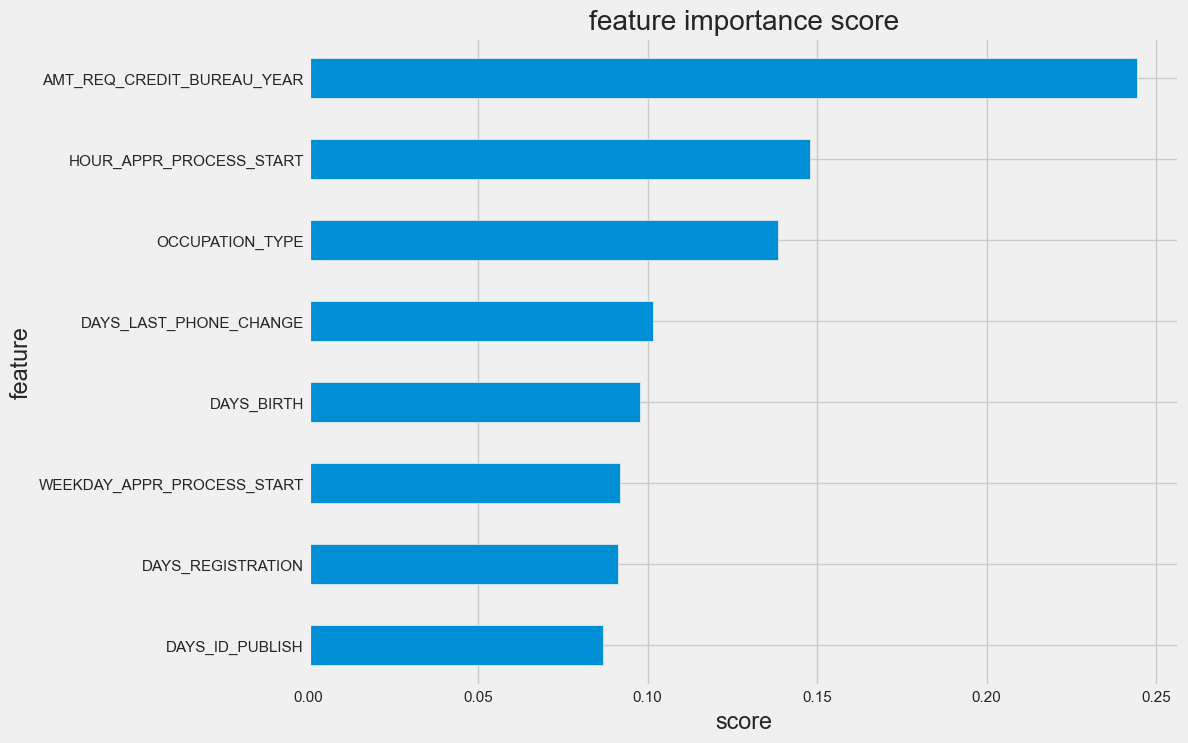

In [50]:
show_feature_importance(dtmodel)

### Hyperparameter Tuning

In [257]:
parameter = {
            'max_depth':[int(x) for x in np.linspace(1, 110, num = 30)],
            'min_samples_split':[2, 5, 10, 100],
            'max_features':['auto', 'sqrt'],
            'criterion':['gini','entropy'],
            'splitter':['best','random']}

dtmodel2 = GridSearchCV(dt, parameter, cv=3, n_jobs = -1 , verbose = 1, scoring='accuracy')
dtmodel2.fit(X_train, y_train)
dtmodelbest = dtmodel2.best_estimator_
y_pred_dt2 = dtmodelbest.predict(X_test)
y_pred_dt2_prob= dtmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [258]:
eval_classification(dtmodelbest)

Accuracy (Test Set): 0.77
Accuracy (Train Set): 0.81
Precision (Test Set): 0.81
Precision (Train Set): 0.85
Recall (Test Set): 0.73
Recall (Train Set): 0.77
F1-Score (Test Set): 0.76
F1-Score (Train Set): 0.81
roc_auc (test-proba): 0.85
roc_auc (train-proba): 0.90


roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.8900101401898771


### **XGBoost**

---

In [51]:
xgmodel = xgb.fit(X_train, y_train)
eval_classification(xgmodel)

Accuracy (Test Set): 0.92
Accuracy (Train Set): 0.92
Precision (Test Set): 1.00
Precision (Train Set): 1.00
Recall (Test Set): 0.84
Recall (Train Set): 0.84
F1-Score (Test Set): 0.91
F1-Score (Train Set): 0.91
roc_auc (test-proba): 0.95
roc_auc (train-proba): 0.96
roc_auc (crossval train): 0.9999999597445219
roc_auc (crossval test): 0.5866993019719617


In [52]:
y_pred_xg_prob = xgmodel.predict_proba(X_test)[:,1]
y_pred_xg = xgmodel.predict(X_test)

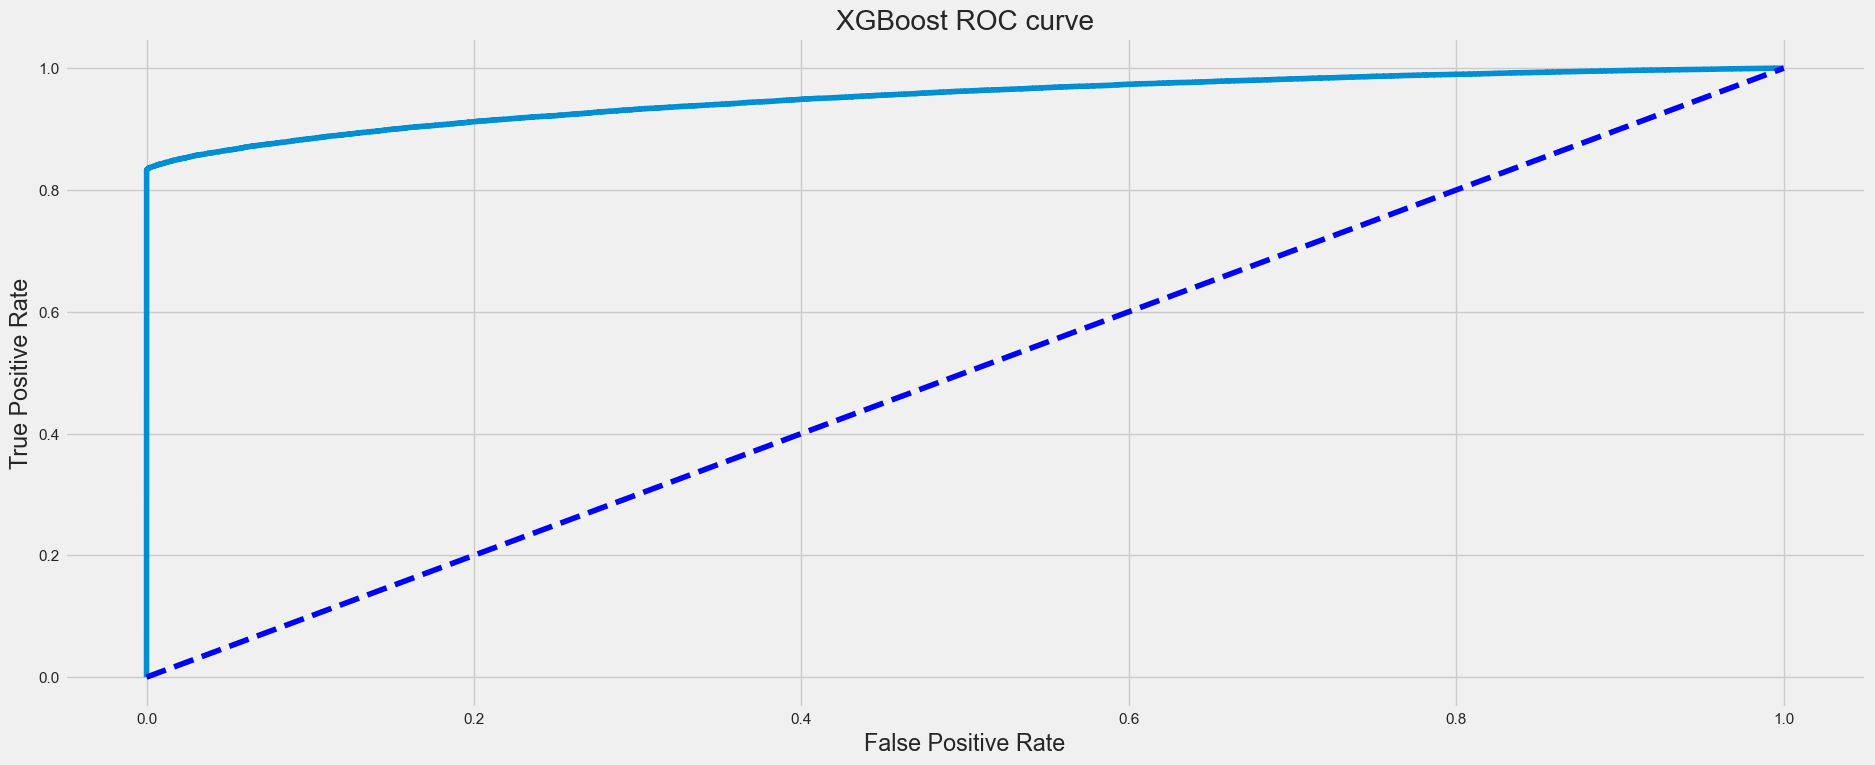

In [53]:
falposr, truposr, _ = roc_curve(y_test, y_pred_xg_prob)
plt.title('XGBoost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[56421   115]
 [ 9229 47310]]



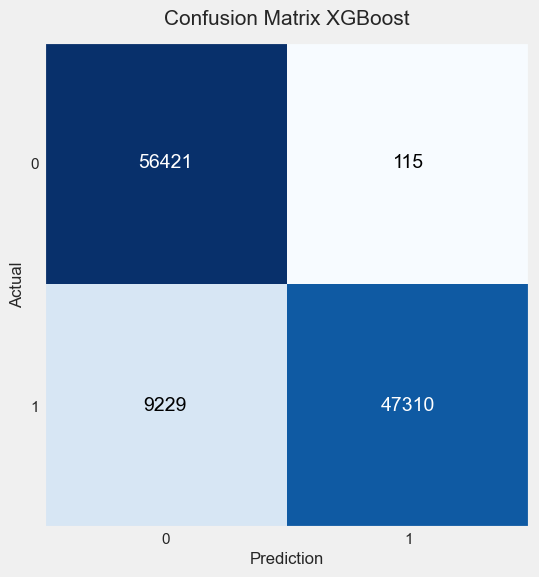

In [54]:
cmxg = confusion_matrix(y_test, y_pred_xg)
print(cmxg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmxg, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix XGBoost', fontsize=15, pad=12)
plt.show()

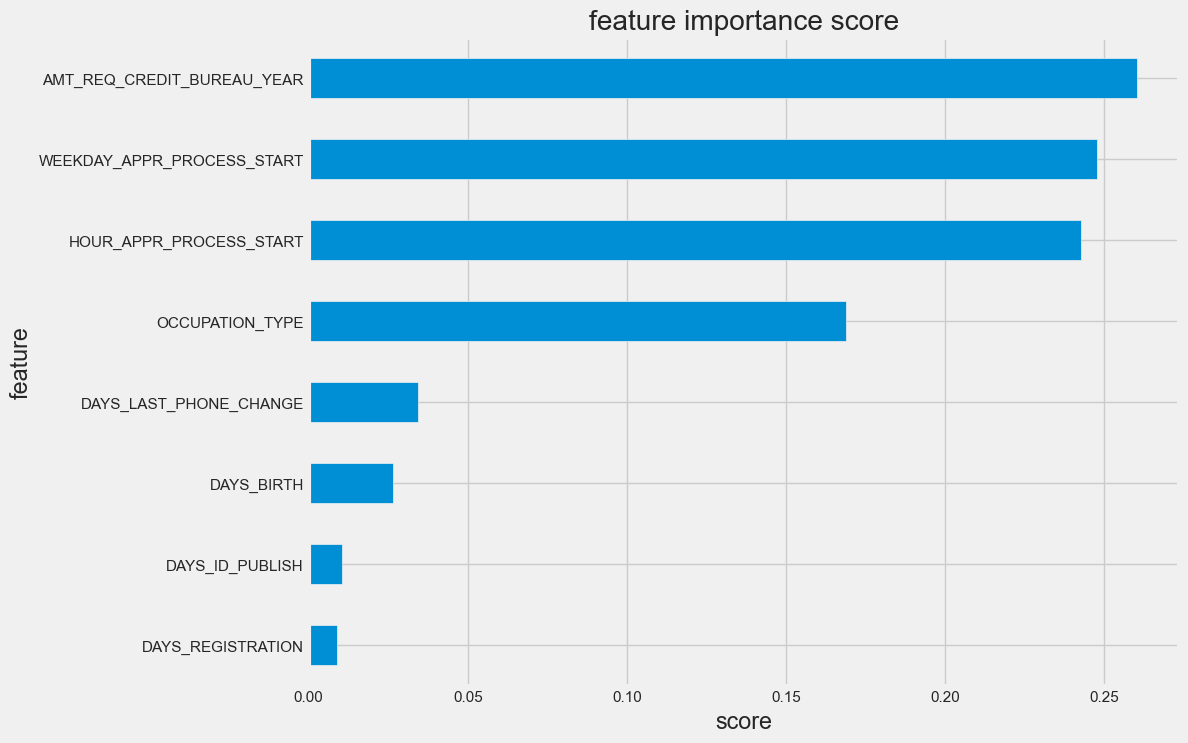

In [55]:
show_feature_importance(xgmodel)

### Hyperparameter Tuning

In [264]:
parameter = {
            'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
            'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
            'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'tree_method' : ['auto', 'exact', 'approx', 'hist'],
            'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],
            'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
            }

xgmodel2 = RandomizedSearchCV(xgb, parameter, cv=3, n_jobs = -1 , verbose = 1, scoring='accuracy', random_state=99)
xgmodel2.fit(X_train,y_train)
xgmodelbest = xgmodel2.best_estimator_
y_pred_xg2 = xgmodelbest.predict(X_test)
y_pred_xg2_prob= xgmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [265]:
eval_classification(xgmodelbest)

Accuracy (Test Set): 0.86
Accuracy (Train Set): 0.86
Precision (Test Set): 0.94
Precision (Train Set): 0.94
Recall (Test Set): 0.77
Recall (Train Set): 0.77
F1-Score (Test Set): 0.85
F1-Score (Train Set): 0.85
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92


roc_auc (crossval train): 0.999999999874011
roc_auc (crossval test): 0.8899437736997771


### **Random Forest**

---

In [120]:
rfmodel = rf.fit(X_train, y_train)
eval_classification(rfmodel)

Accuracy (Test Set): 0.95
Accuracy (Train Set): 1.00
Precision (Test Set): 0.99
Precision (Train Set): 1.00
Recall (Test Set): 0.91
Recall (Train Set): 1.00
F1-Score (Test Set): 0.95
F1-Score (Train Set): 1.00
roc_auc (test-proba): 0.98
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.9999999446264889
roc_auc (crossval test): 0.5678656287042603


In [137]:
y_pred_rf_prob = rfmodel.predict_proba(X_test)[:,1]
y_pred_rf = rfmodel.predict(X_test)

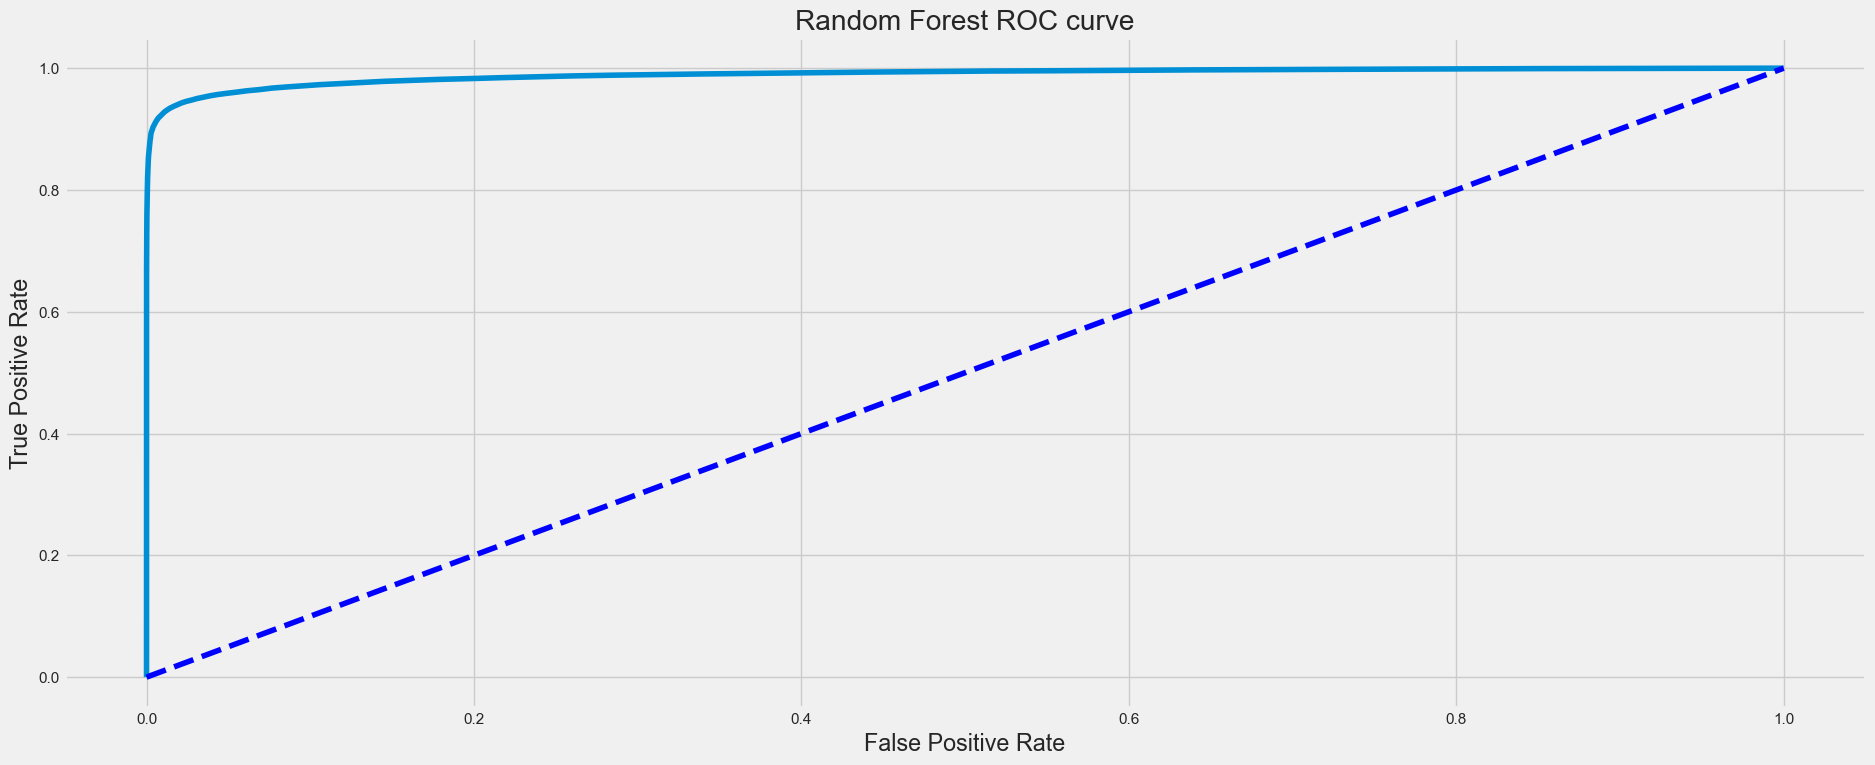

In [139]:
falposr, truposr, _ = roc_curve(y_test, y_pred_rf_prob)
plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[55833   703]
 [ 3901 52638]]



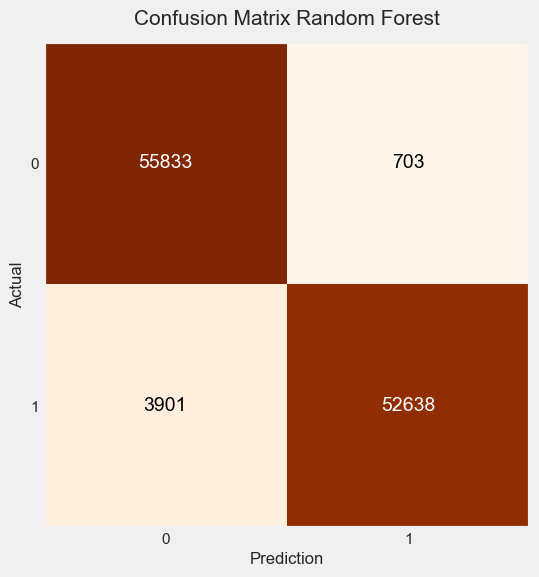

In [141]:
cmrf = confusion_matrix(y_test, y_pred_rf)
print(cmrf)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmrf, figsize=(6, 6), cmap=plt.cm.Oranges)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Random Forest', fontsize=15, pad=12)
plt.show()

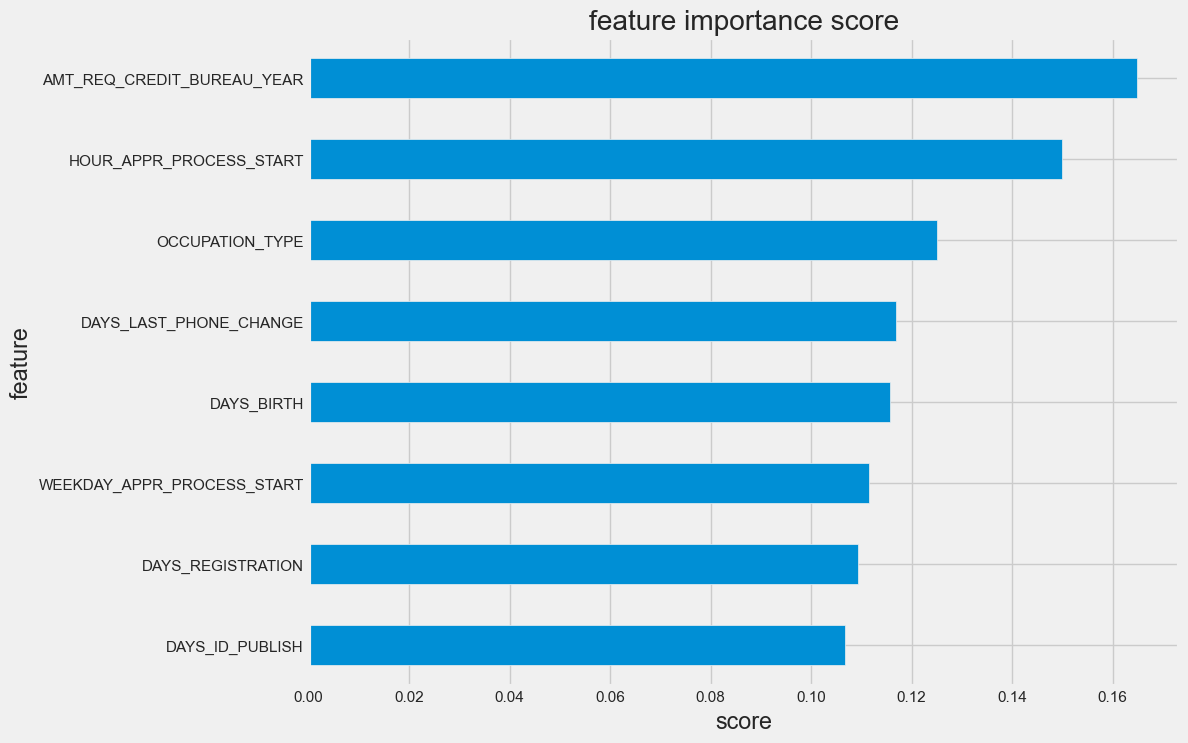

In [142]:
show_feature_importance(rfmodel)

### Hyperparameter Tuning

In [39]:
parameter = {'n_estimators': [int(x) for x in np.linspace(1, 200, 50)],
            'criterion': ['gini', 'entropy'],
            'max_depth': [int(x) for x in np.linspace(2, 100, 50)],
            'min_samples_split': [int(x) for x in np.linspace(2, 20, 10)],
            'min_samples_leaf': [int(x) for x in np.linspace(2, 20, 10)],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]
            }

rsmodel2 = RandomizedSearchCV(rf, parameter, cv=5, n_jobs = -1 , verbose = 1, scoring='accuracy', random_state=99)
rsmodel2.fit(X_train,y_train)
rsmodelbest = rsmodel2.best_estimator_
y_pred_rs2 = rsmodelbest.predict(X_test)
y_pred_rs2_prob= rsmodelbest.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [40]:
eval_classification(rsmodelbest)

Accuracy (Test Set): 0.94
Accuracy (Train Set): 0.97
Precision (Test Set): 0.98
Precision (Train Set): 1.00
Recall (Test Set): 0.90
Recall (Train Set): 0.95
F1-Score (Test Set): 0.94
F1-Score (Train Set): 0.97
roc_auc (test-proba): 0.98
roc_auc (train-proba): 1.00
roc_auc (crossval train): 0.9999999486119521
roc_auc (crossval test): 0.5902380582689466


### **LightGBM**

---

In [61]:
lgbmodel = lgb.fit(X_train, y_train)
print('')
eval_classification(lgbmodel)

[LightGBM] [Info] Number of positive: 226147, number of negative: 226150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 452297, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499997 -> initscore=-0.000013
[LightGBM] [Info] Start training from score -0.000013

Accuracy (Test Set): 0.93
Accuracy (Train Set): 0.93
Precision (Test Set): 1.00
Precision (Train Set): 1.00
Recall (Test Set): 0.86
Recall (Train Set): 0.86
F1-Score (Test Set): 0.93
F1-Score (Train Set): 0.93
roc_auc (test-proba): 0.96
roc_auc (train-proba): 0.96
roc_auc (crossval train): 0.9999999407746131
roc_auc (crossval test): 0.5896044588655246


In [62]:
y_pred_lgb_prob = lgbmodel.predict_proba(X_test)[:,1]
y_pred_lgb = lgbmodel.predict(X_test)

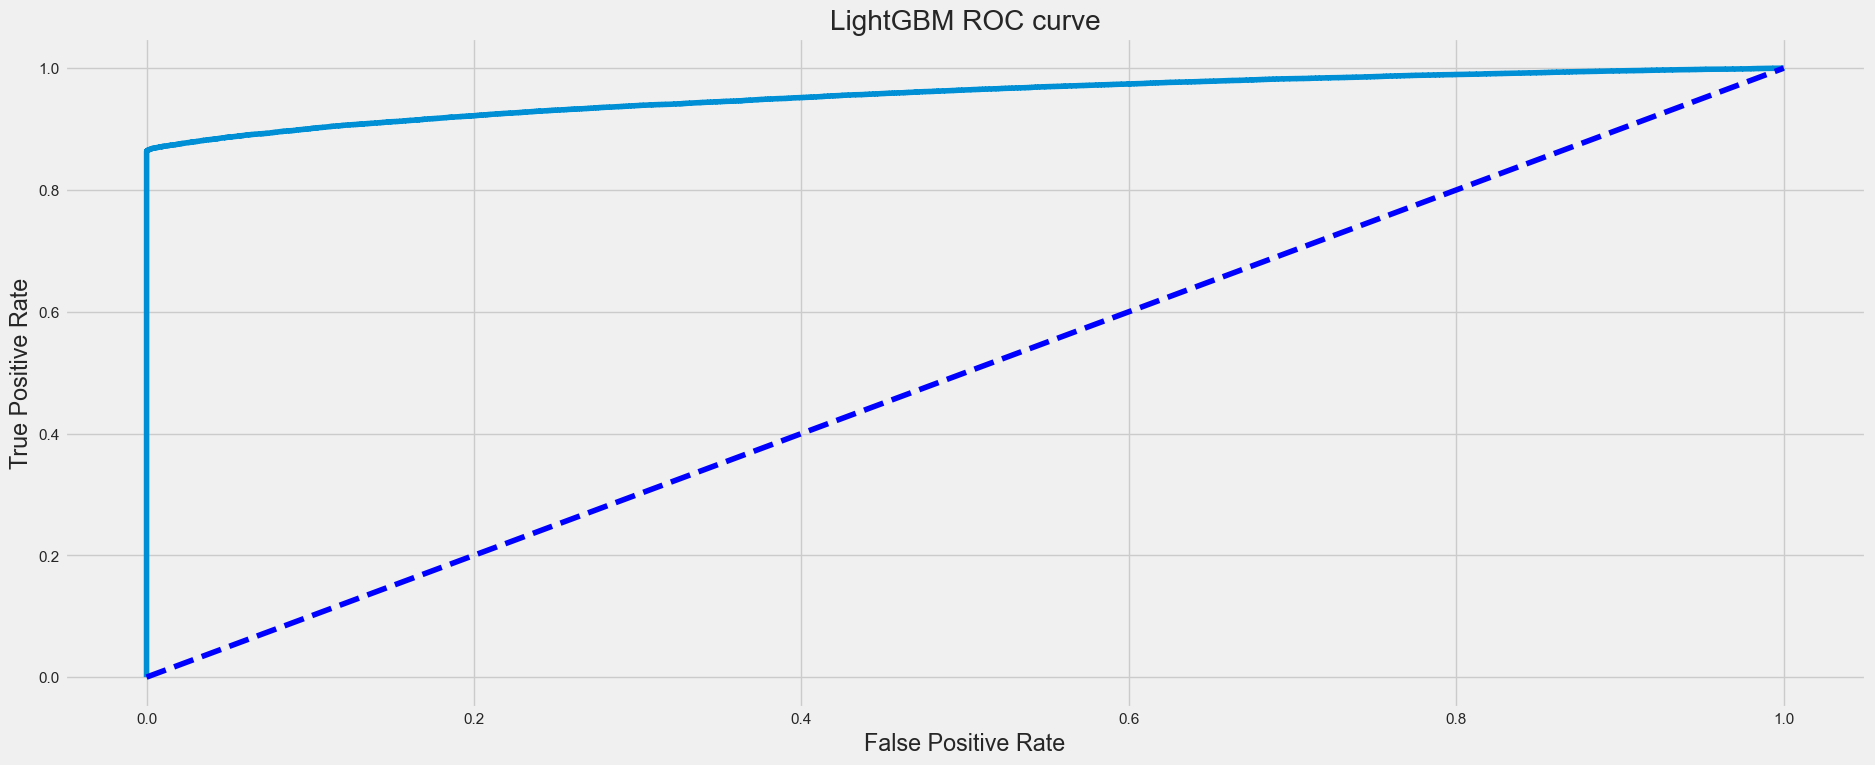

In [63]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lgb_prob)
plt.title('LightGBM ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[56530     6]
 [ 7722 48817]]



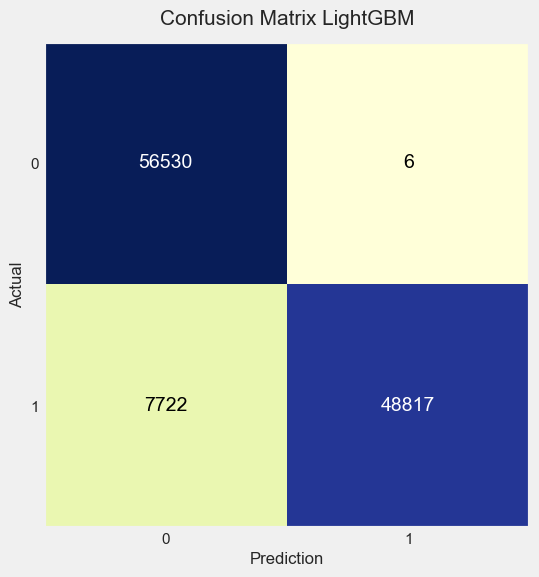

In [64]:
cmlgb = confusion_matrix(y_test, y_pred_lgb)
print(cmlgb)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlgb, figsize=(6, 6), cmap=plt.cm.YlGnBu)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix LightGBM', fontsize=15, pad=12)
plt.show()

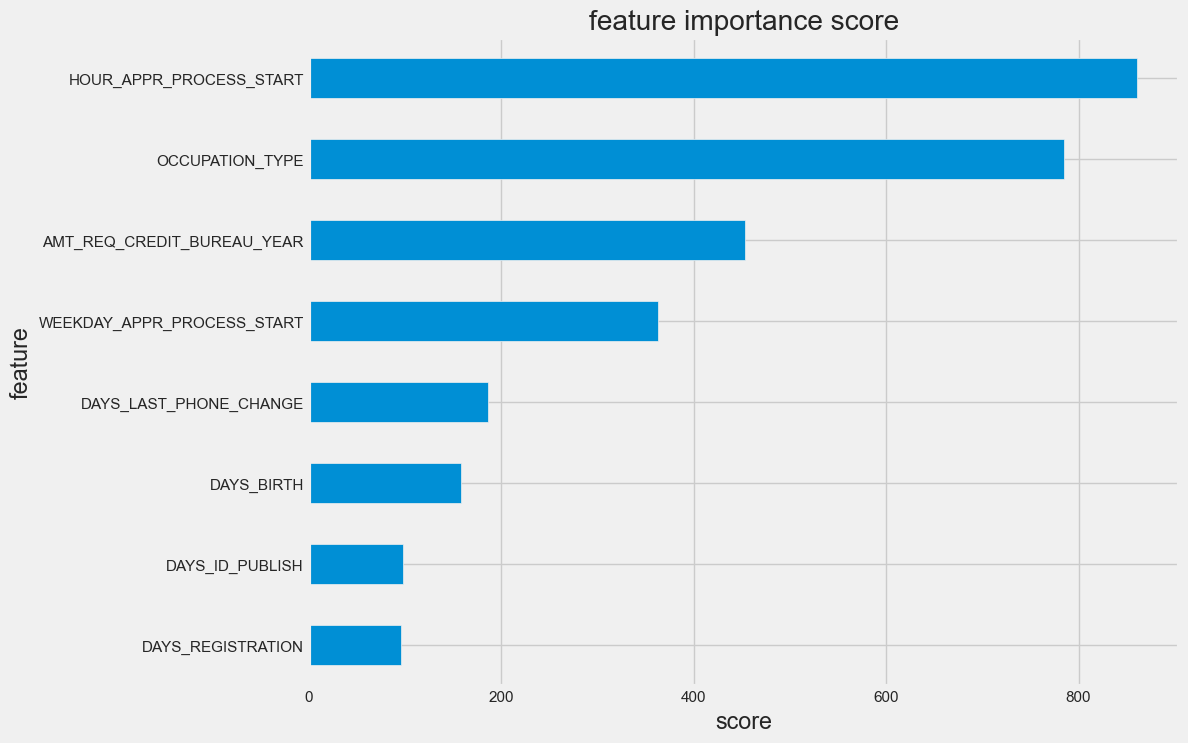

In [65]:
show_feature_importance(lgbmodel)

### Hyperparameter Tuning

In [278]:
f2 = make_scorer(fbeta_score, beta =2)
parameter = {"n_estimators":[200,300,400],
             "max_depth":[3,5,9],
             "num_leaves":[20,120],
             "learning_rate":[0.01,0.1],
             "min_child_samples":[10,50]}
lgbmodel2 = HalvingGridSearchCV(lgb, parameter, scoring = f2, cv=3, n_jobs = -1, verbose = 1)
lgbmodel2.fit(X_train,y_train)
lgbmodel2.best_params_, lgbmodel2.best_score_
lgbmodelbest = LGBMClassifier(**lgbmodel2.best_params_)
lgbmodelbest.fit(X_train, y_train)
y_pred_lgb2 = lgbmodelbest.predict(X_test)
y_pred_lgb2_prob = lgbmodelbest.predict_proba(X_test)[:,1]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4083
max_resources_: 110259
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 4083
Fitting 3 folds for each of 72 candidates, totalling 216 fits


----------
iter: 1
n_candidates: 24
n_resources: 12249
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 36747
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 110241
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56014, number of negative: 54245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 110259, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508022 -> initscore=0.032091
[LightGBM] [Info] Start training from score 0.032091
[LightGBM] [Warning

In [279]:
eval_classification(lgbmodelbest)

Accuracy (Test Set): 0.84
Accuracy (Train Set): 0.85
Precision (Test Set): 0.90
Precision (Train Set): 0.90
Recall (Test Set): 0.79
Recall (Train Set): 0.79
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92


roc_auc (crossval train): 0.9999999998992092
roc_auc (crossval test): 0.8898173192608156


### **Gradient Boost**

---

In [66]:
grdmodel = grd.fit(X_train, y_train)
eval_classification(grdmodel)

Accuracy (Test Set): 0.88
Accuracy (Train Set): 0.88
Precision (Test Set): 0.97
Precision (Train Set): 0.97
Recall (Test Set): 0.78
Recall (Train Set): 0.78
F1-Score (Test Set): 0.87
F1-Score (Train Set): 0.87
roc_auc (test-proba): 0.93
roc_auc (train-proba): 0.93
roc_auc (crossval train): 0.9999999337833442
roc_auc (crossval test): 0.5879295289760258


In [67]:
y_pred_grd_prob = grdmodel.predict_proba(X_test)[:,1]
y_pred_grd = grdmodel.predict(X_test)

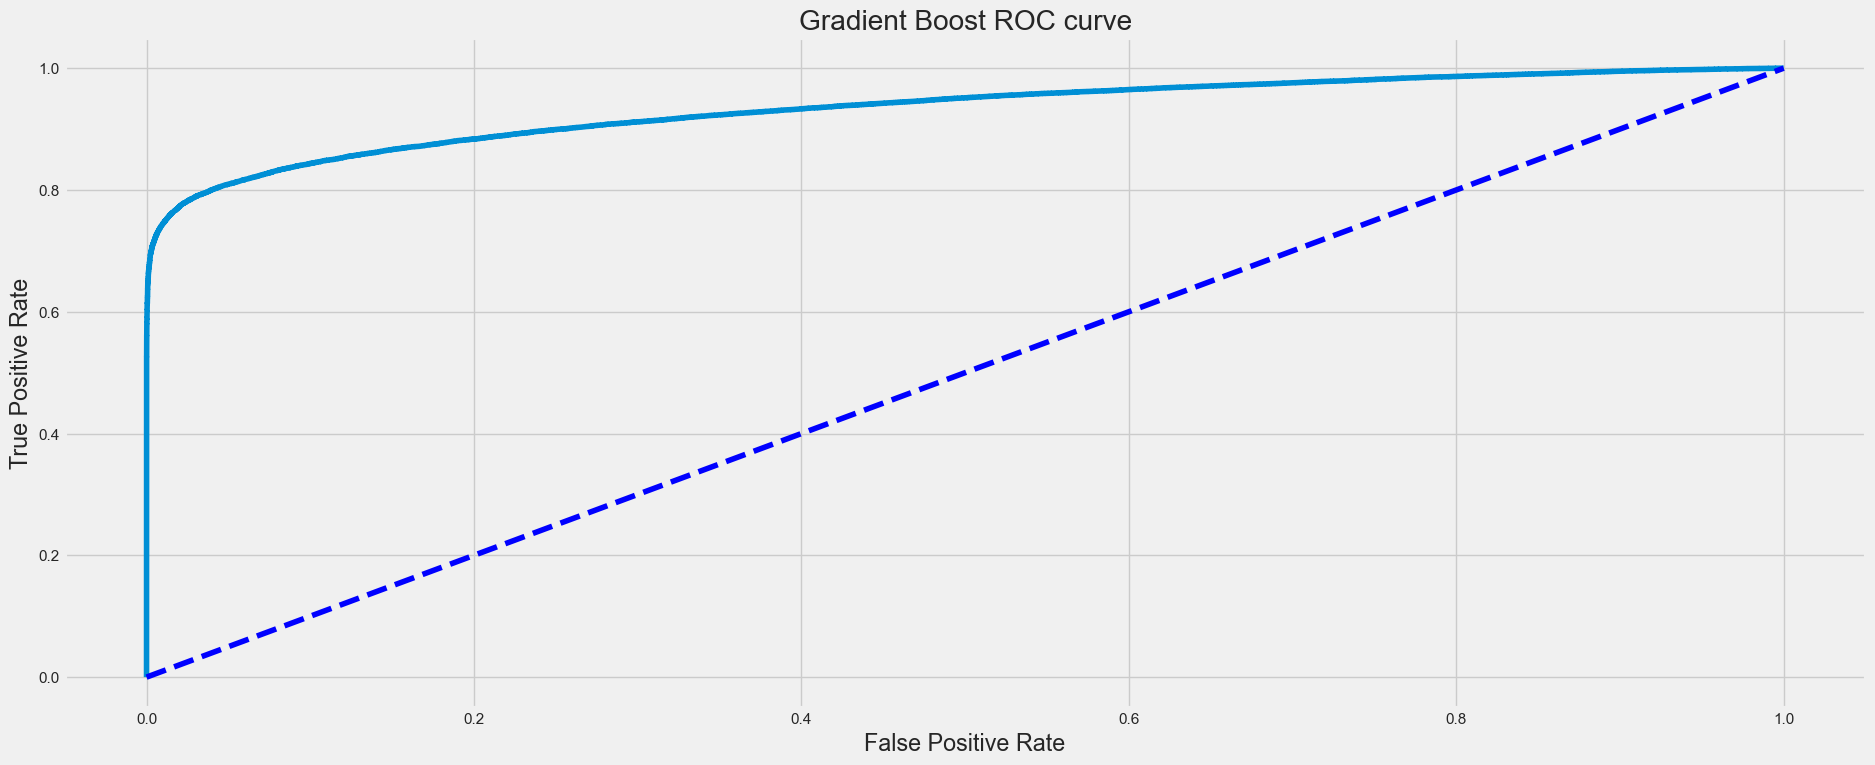

In [68]:
falposr, truposr, _ = roc_curve(y_test, y_pred_grd_prob)
plt.title('Gradient Boost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[55111  1425]
 [12319 44220]]



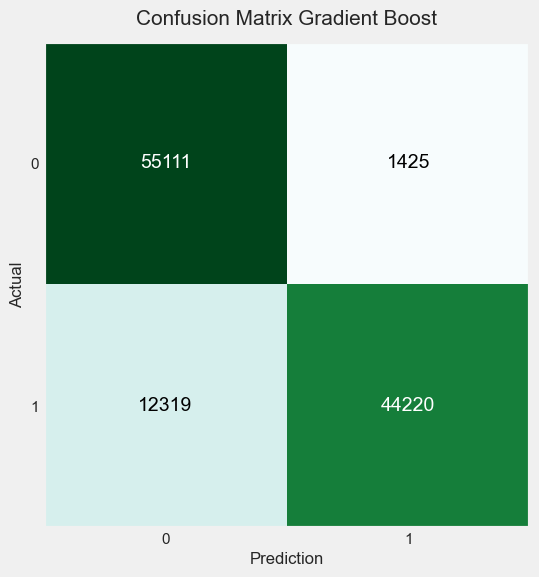

In [69]:
cmgrd = confusion_matrix(y_test, y_pred_grd)
print(cmgrd)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmgrd, figsize=(6, 6), cmap=plt.cm.BuGn)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Gradient Boost', fontsize=15, pad=12)
plt.show()

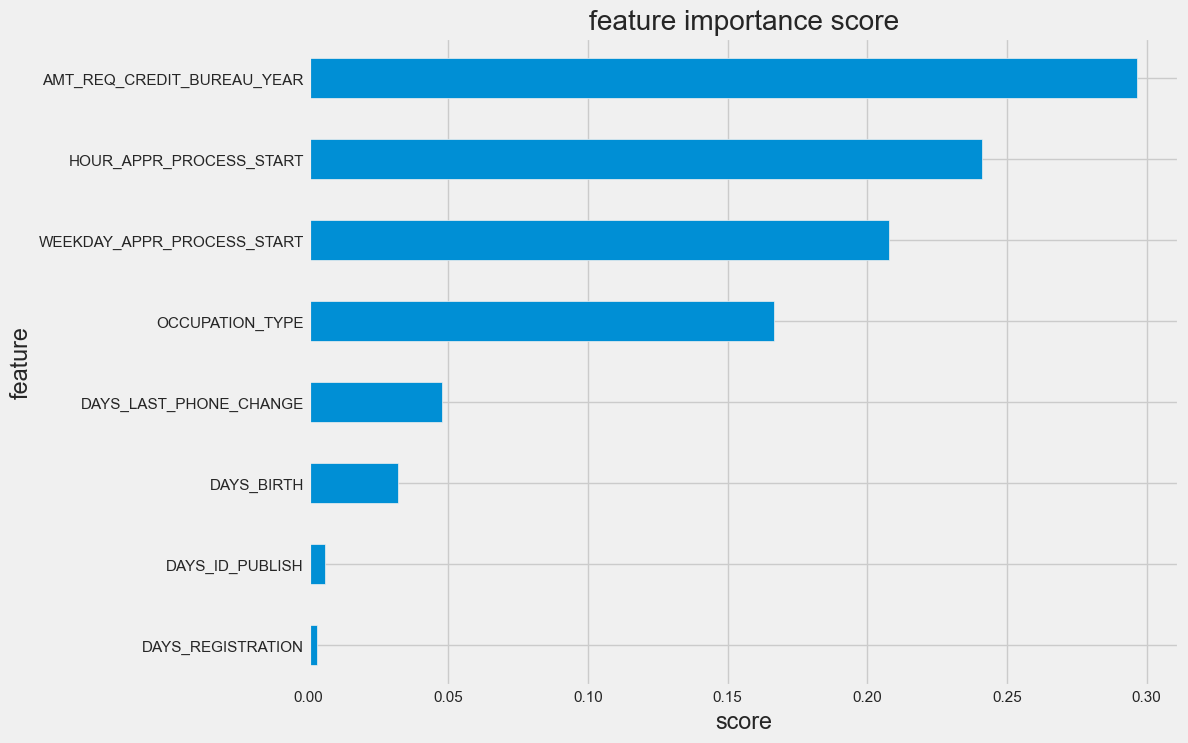

In [70]:
show_feature_importance(grdmodel)

In [285]:
parameter = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
             'n_estimators':[100,250,500,750,1000,1250,1500,1750],
             'max_depth':[3,4,5,6,7,8],
             'min_samples_split':[2,3,4,5],
             'min_samples_leaf':[1,2],
             'max_features':['sqrt','auto']}

grdmodel2 = RandomizedSearchCV(grd, parameter, scoring='accuracy', n_jobs=-1, cv=3, verbose=1)
grdmodel2.fit(X_train,y_train)
grdmodel2.best_params_, grdmodel2.best_score_
grdmodelbest = GradientBoostingClassifier(**grdmodel2.best_params_)
grdmodelbest.fit(X_train, y_train)
y_pred_grd2 = grdmodelbest.predict(X_test)
y_pred_grd2_prob = grdmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [286]:
eval_classification(grdmodelbest)

Accuracy (Test Set): 0.85
Accuracy (Train Set): 0.89
Precision (Test Set): 0.92
Precision (Train Set): 0.95
Recall (Test Set): 0.78
Recall (Train Set): 0.82
F1-Score (Test Set): 0.85
F1-Score (Train Set): 0.88
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.96
roc_auc (crossval train): 0.9999999999748022
roc_auc (crossval test): 0.8897892035876687


>## Conclusion

Model yang dipilih adalah model `Random Forest` yang belum di tuning parameternya. Metrix utama yang digunakan adalah `ROC-AUC` yang dimana menunjukkan seberapa baik model membedakan antara kelas. Nilai AUC yang tinggi menunjukkan bahwa model memiliki kemampuan yang baik untuk membedakan antara peminjam yang berisiko dan yang tidak, serta `Precision` yang dimana kita tidak ingin **False Positive** tinggi atau mengurangi **False Positive** sekecil-kecilnya ( untuk meminimalkan jumlah peminjam berisiko tinggi yang disetujui ).<br>

>## The Best Fit Model

## `Random Forest Model`

Model ini memiliki nilai `Precision` yang tinggi pada kedua data latihan **(1.00)** dan data uji **(0.99)** menunjukkan bahwa model cukup handal dalam memprediksi kelas positif, yang penting dalam konteks credit scoring untuk meminimalkan risiko kredit macet. Serta nilai `ROC-AUC` yang tinggi untuk probabilitas pada data latihan **(1.00)** dan data uji **(0.99)** menunjukkan bahwa model memiliki kemampuan yang baik dalam membedakan antara kelas positif dan negatif. Model tidak overfit maupun underfit yang dapat disebut sebagai model ***best fit***.

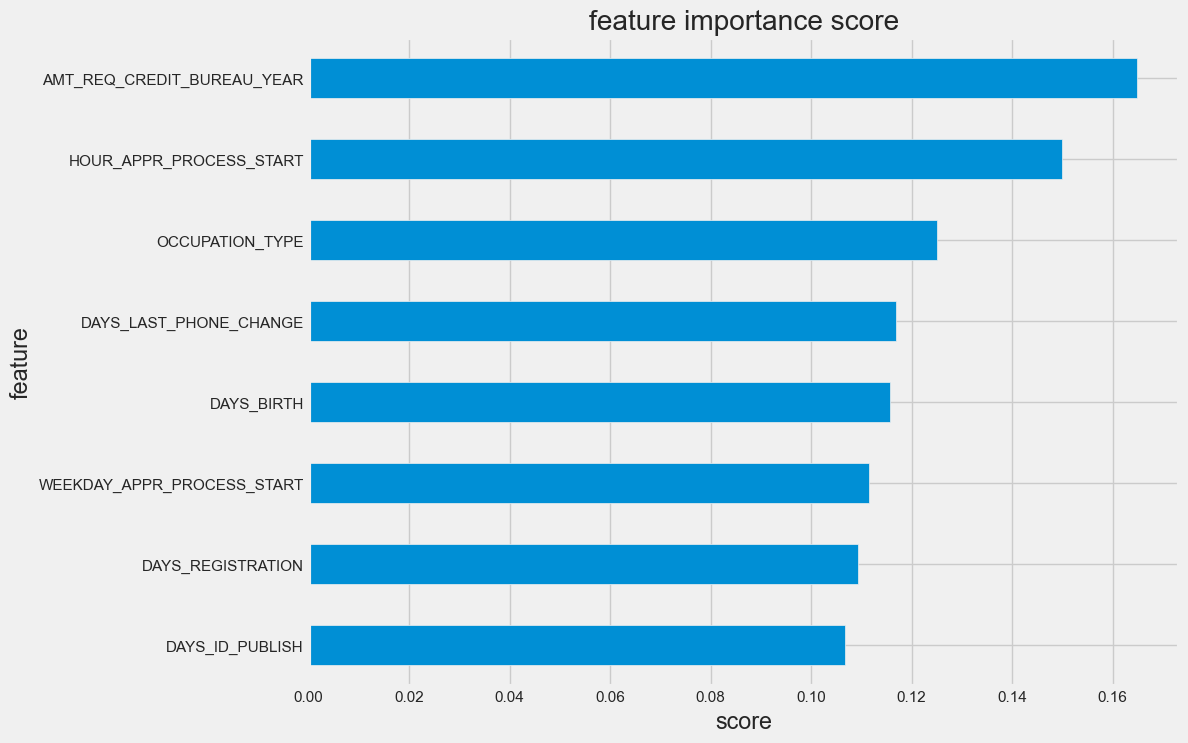

In [71]:
show_feature_importance(rfmodel)

AMT_REQ_CREDIT_BUREAU_YEAR, HOUR_APPR_PROCESS_START, OCCUPATION_TYPE, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH, WEEKDAY_APPR_PROCESS_START, DAYS_REGISTRATION, DAYS_ID_PUBLISH

In [72]:
import shap

# Melihat shap value tiap features
explainer = shap.TreeExplainer(rfmodel)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [294]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[0,:])

>## **Business Recomendations**

- `Penargetan Berdasarkan Tingkat Pendidikan`: tingkat pendidikan memiliki pengaruh yang signifikan terhadap kemungkinan individu memiliki kredit yang baik. Individu dengan tingkat pendidikan yang lebih tinggi umumnya memiliki penghasilan yang lebih tinggi dan stabilitas kerja yang lebih baik, sehingga mereka lebih kecil kemungkinannya untuk gagal membayar pinjaman. <br>
- `Penawaran Kredit Berdasarkan Jumlah Anggota Keluarga`: anggota keluarga memiliki pengaruh terhadap kemungkinan individu memiliki kredit yang baik. Individu dengan jumlah anggota keluarga yang lebih sedikit mungkin memiliki beban keuangan yang lebih ringan dan lebih mampu mengelola pembayaran pinjaman. <br>
- `Mempertimbangkan Ketidakcocokan Tempat Tinggal dan Tempat Kerja`: lokasi tempat tinggal dan tempat kerja individu dapat memengaruhi kemungkinan mereka memiliki kredit yang baik. Individu yang tinggal di wilayah yang sama dengan tempat kerja mereka mungkin lebih mudah diverifikasi dan dianggap memiliki risiko kredit yang lebih rendah. <br>
- `Mempertimbangkan Jenis Pekerjaan`: jenis pekerjaan individu dapat memengaruhi kemungkinan mereka memiliki kredit yang baik. Individu dengan pekerjaan yang stabil dan berpenghasilan tetap mungkin dianggap memiliki risiko kredit yang lebih rendah. <br>
- `Menargetkan Berdasarkan Status Pernikahan`: status pernikahan individu dapat memengaruhi kemungkinan mereka memiliki kredit yang baik. Individu yang menikah mungkin memiliki stabilitas keuangan yang lebih baik dan lebih kecil kemungkinannya untuk gagal membayar pinjaman.